In [2]:
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import pandas as pd
import re

import time
import torch
import torch.nn

import random
import pickle


In [3]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
4
Tesla V100-SXM2-32GB


In [4]:
import torch.backends.cudnn as cudnn
if torch.cuda.is_available():
    device = torch.device("cuda:2")
    # work on a single GPU or CPU
    cudnn.benchmark=True
else:
    device = torch.device("cpu")
    cudnn.benchmark=False

print(device)
print(torch.cuda.get_device_name(0))

cuda:2
Tesla V100-SXM2-32GB


In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# 1. Load model

In [6]:
def balanced_over_sampling(X, y, random_seed=123):
    np.random.seed(random_seed)
    unique_value, unique_value_counts = np.unique(y, return_counts=True)
    train_class_max = np.max(unique_value_counts)
    train_samples_idx = []
    for i, y_unique in enumerate(unique_value):
        train_one_class_idx = np.where(y==y_unique)[0]
        train_one_sample_idx = np.concatenate([train_one_class_idx,
                                               np.random.choice(train_one_class_idx, 
                                                                size=train_class_max-len(train_one_class_idx), replace=True)])
        train_samples_idx.append(train_one_sample_idx)
    train_balanced_idx = np.random.permutation(np.concatenate(train_samples_idx))
    return X[train_balanced_idx], y[train_balanced_idx]

In [7]:
class Classifier(torch.nn.Module):
    def __init__(self, n_in_features, net_hidden_structure, n_out_features, dropout_rate):
        super(Classifier, self).__init__()
        net_fcs = []
        structure = net_hidden_structure
        net_in_shape = n_in_features
        for i, net_n_hidden_nodes in enumerate(structure):
            net_fcs.append(torch.nn.Linear(net_in_shape, net_n_hidden_nodes))
            net_fcs.append(torch.nn.BatchNorm1d(net_n_hidden_nodes))
            net_fcs.append(torch.nn.ReLU6())
            net_fcs.append(torch.nn.Dropout(p=dropout_rate))
            net_in_shape = net_n_hidden_nodes
        net_fcs.append(torch.nn.Linear(net_in_shape, n_out_features))
        self.net_fcs = torch.nn.ModuleList(net_fcs)
        
    def forward(self, x):
        net_fcs = self.net_fcs
        for net_fc in net_fcs:
            x = net_fc(x)
        return x

In [8]:
from torch.utils.data import Dataset, DataLoader
class Dataset(Dataset):
    """Self-defined dataset."""

    def __init__(self, X, y):
        """
        Args:
            X: microbiome data
            y: response data
        """
        self.X = torch.from_numpy(X).float() if not torch.is_tensor(X) else X.float()
        self.y = torch.LongTensor(y) if not torch.is_tensor(y) else y.long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
def load_model(X,y, disease, dropout_rate, weight_decay,
              lr=0.001, momentum=0.9, random_state=123, device='cuda:0', print_loss=True):
    
    import torch
    import torch.nn as nn
    import random
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    random.seed(random_state)
    #torch.set_deterministic(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
    
    ### training, testing split
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
    X_train_balanced, y_train_balanced = balanced_over_sampling(np.array(X_train), np.array(y_train))

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(y)
    y_train_balanced_le = le.transform(y_train_balanced)
    y_test_le = le.transform(y_test)
    classes = le.classes_
    label_dim = len(classes)

    classifier = Classifier(n_in_features=X.shape[1], net_hidden_structure = [512, 128, 32, 8], 
                            n_out_features=label_dim, dropout_rate=dropout_rate)
    classifier.to(device)
    optimizer = torch.optim.SGD(classifier.parameters(), lr=lr, momentum=momentum, weight_decay = weight_decay)
    
    model_save_path = './models/{}/{}'.format(disease, y.name)

    ### If you are running on a CPU-only machine, add "map_location=torch.device('cpu')".
    if torch.cuda.is_available():
        checkpoint = torch.load(os.path.join(model_save_path, '{}.pth'.format(y_train.name)),
                                map_location=torch.device('cuda:0'))
    else:
        checkpoint = torch.load(os.path.join(model_save_path, '{}.pth'.format(y_train.name)), 
                                map_location=torch.device('cpu'))
        
    hist = checkpoint['history']
    classifier.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return classifier, optimizer, hist, X_test, y_test_le, classes

In [10]:
def predict_mlp(classifier, optimizer, X_test, y_test_le, classes, device='cpu'):
    classifier.eval()
    with torch.no_grad():
        prediction = classifier(torch.tensor(np.array(X_test, dtype='float32')).to(device))
        pred_proba = torch.nn.Softmax(dim=1)(prediction)
    y_pred = classes[pred_proba.argmax(axis=1).cpu().numpy()]
    y_test_true = classes[y_test_le]
    
    accuracy = sum(y_pred==y_test_true)/len(y_pred)
    
    from sklearn.metrics import confusion_matrix
    confusion_mat = confusion_matrix(y_test_true, y_pred)
    
    from sklearn.metrics import roc_auc_score
    y_pred_proba = pred_proba[:,1].cpu().numpy() if pred_proba.shape[1]==2 else pred_proba.cpu().numpy()
    auc = roc_auc_score(y_test_true, y_pred_proba)
    
    return pred_proba, y_pred, accuracy, confusion_mat, auc
    

# 2. LRP

In [11]:
def get_activations(classifier, X, device='cuda:0'):
    activations = []
    classifier.to(device)
    classifier.eval()
    with torch.no_grad():
        _acti = torch.tensor([X]).float().to(device)
        for i, _module in enumerate(list(classifier.modules())[1]):
            _acti = _module(_acti)
            activations.append(_acti)
    return activations

In [12]:
### Reference: https://git.tu-berlin.de/gmontavon/lrp-tutorial
def rho1(w, a):
    aw = a.cpu().detach().numpy() * w.cpu().detach().numpy()
    return ((aw > 0) * w.cpu().detach().numpy()).squeeze()
def rho2(w, a):
    aw = a.cpu().detach().numpy() * w.cpu().detach().numpy()
    return ((aw < 0) * w.cpu().detach().numpy()).squeeze()
### LRP-epsilon
def incr(z, epsilon_coef=0.1): 
    return z + epsilon_coef * (z**2).mean()**.5

In [13]:
### Reference: https://git.tu-berlin.de/gmontavon/lrp-tutorial/-/blob/main/utils.py
import copy
def newlayer1(layer,g):

    layer = copy.deepcopy(layer)

    layer.weight = torch.nn.Parameter(torch.tensor(g(layer.weight)).to(device))
    layer.bias   = torch.nn.Parameter(torch.tensor(np.maximum(0,layer.bias.cpu().detach().numpy())).to(device))

    return layer

def newlayer2(layer,g):

    layer = copy.deepcopy(layer)

    layer.weight = torch.nn.Parameter(torch.tensor(g(layer.weight)).to(device))
    layer.bias   = torch.nn.Parameter(torch.tensor(np.minimum(0,layer.bias.cpu().detach().numpy())).to(device))

    return layer

In [14]:
def relprop(a, layer, R_k, alpha=2., beta=1., epsilon_coef=0.):
    import copy
    a1 = copy.deepcopy(a)
    z1 = newlayer1(layer, lambda x: rho1(x,a1.data)).forward(a1)         # step 1
    z1 = incr(z1, epsilon_coef)                                          # step 1
    s1 = R_k/(z1+1e-9)                                                   # step 2
    (z1*s1.data).sum().backward()                                        # step 3
    c1 = a1.grad                                                         # step 3
    R_j1 = alpha*a1*c1                                                   # step 4
    
    a2 = copy.deepcopy(a)
    z2 = newlayer2(layer, lambda x: rho2(x,a2.data)).forward(a2)          # step 1
    z2 = incr(z2, epsilon_coef)                                           # step 1
    s2 = R_k/(z2+1e-9)                                                    # step 2
    (z2*s2.data).sum().backward()                                         # step 3
    c2 = a2.grad                                                          # step 3
    R_j2 = beta*a2*c2                                                     # step 4
    return R_j1 - R_j2

In [15]:
def LRP(classifier, X_onerow, feature_idx, classes, device='cuda:0'):
    A = get_activations(classifier, X_onerow, device=device)
    A.insert(0, torch.FloatTensor(np.array(X_onerow)).to(device))
    LAYER = list(classifier.modules())[1]
    L = len(LAYER)
    R = [None]*(L+1)
    R[-1] = torch.tensor([0.0]*len(classes)).float().to(device)
    
    for idx in feature_idx:
        R[-1][idx] = A[-1].squeeze()[idx]
    for l in range(L)[::-1]:
        if isinstance(LAYER[l],torch.nn.Linear):
            A[l] = (A[l]).requires_grad_(True)
            R[l] = relprop(A[l], LAYER[l], R[l+1])
        else:
            R[l] = R[l+1]
    return R, A

In [16]:
### Reference: B-LRP - https://github.com/lapalap/B-LRP/blob/master/B_LRP_MNIST.ipynb

# Function for MinMax Normalisation of Relevances

def normalise_relevance(relevance_matrix):
    a = relevance_matrix.min()
    b = relevance_matrix.max()
    
    if (a == 0.) & (b == 0.):
        return relevance_matrix
    if (a >= 0.):
        return (relevance_matrix>=0.) * relevance_matrix/b
    if (b <= 0.):
        return - ((relevance_matrix<=0.) * relevance_matrix/a)
    else:
        return (relevance_matrix>0.) * relevance_matrix/b  - ((relevance_matrix<=0.)*relevance_matrix/a)


In [17]:
def lrp_analysis_mutation(classifier, X_microbiome, y_nonan_disc, classes, 
                          quantile_cut = 0.95, device='cuda:0', random_state=123):
    
    import torch
    import torch.nn as nn
    import random
    import numpy as np
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    random.seed(random_state)
    #torch.set_deterministic(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        
    R_0_mutation, prediction = [], []
    for i in range(X_microbiome.shape[0]):
        y_feature_idx = np.where(classes==y_nonan_disc[i])[0]
        R_onerow, A_onerow = LRP(classifier, X_microbiome.iloc[i,:], y_feature_idx,
                                 classes, device=device)
        R_0_onerow = normalise_relevance(R_onerow[0]) ### Add minmax normalization here
        predict_onerow = A_onerow[-1].squeeze()[y_feature_idx]
        R_0_mutation.append(R_0_onerow.cpu().detach().numpy())
        prediction.append(predict_onerow.cpu().detach().numpy())
    R_0_mutation = np.array(R_0_mutation)
    prediction = np.array(prediction)
    
    ### Analysis on Relevance Score
    ### 1. Influence by row sum of absolute value of R0 (care about both excitatory and inhibitory effects)
    influence_by_microbe = np.sum(np.abs(R_0_mutation), axis=0)
    ### 2. significant count (by quantile/p-value)
    R_0_mutation_qcut = np.zeros(R_0_mutation.shape)
    for i in range(R_0_mutation.shape[0]):
        cutoff = np.quantile(R_0_mutation[i,:], quantile_cut)
        R_0_mutation_qcut[i,:] = R_0_mutation[i,:] >= cutoff
    ### 3. spearman correlation
    from scipy.stats import spearmanr
    correlation = []
    for j in range(R_0_mutation.shape[1]):
        correlation.append(spearmanr(R_0_mutation[:,j], prediction).correlation)
    return R_0_mutation, R_0_mutation_qcut, influence_by_microbe, correlation

In [18]:
# def lrp_analysis_mutation(classifier, X_microbiome, y_mutation_cnv_one, classes,
#                           quantile_cut = 0.95, device='cuda:0', random_state=123):
    
#     import torch
#     import torch.nn as nn
#     import random
#     import numpy as np
#     torch.manual_seed(random_state)
#     np.random.seed(random_state)
#     random.seed(random_state)
#     #torch.set_deterministic(True)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed_all(random_state)
    
#     R_0_mutation, prediction = [], []
#     for i in range(X_microbiome.shape[0]):
#         y_feature_idx = np.where(classes==y_mutation_cnv_one.iloc[i])[0]
#         R_onerow, A_onerow = LRP(classifier, X_microbiome.iloc[i,:], y_feature_idx,
#                          classes, device=device)
#         R_0_onerow = R_onerow[0]
#         predict_onerow = A_onerow[-1].squeeze()[y_feature_idx]
#         R_0_mutation.append(R_0_onerow.cpu().detach().numpy())
#         prediction.append(predict_onerow.cpu().detach().numpy())
#     R_0_mutation = np.array(R_0_mutation)
#     prediction = np.array(prediction)
#     ### Remove NaN rows
#     notnan_idx = np.where(~np.isnan(R_0_mutation[:,0]))[0]
#     R_0_mutation = R_0_mutation[notnan_idx,:]
#     prediction = prediction[notnan_idx,:]
    
#     ### Analysis on Relevance Score
#     ### 1. significant count (by quantile/p-value)
#     R_0_mutation_qcut = np.zeros(R_0_mutation.shape)
#     for i in range(R_0_mutation.shape[0]):
#         cutoff = np.quantile(R_0_mutation[i,:], quantile_cut)
#         R_0_mutation_qcut[i,:] = R_0_mutation[i,:] >= cutoff
#     influence_by_microbe = np.sum(R_0_mutation_qcut, axis=0)
#     ### 2. spearman correlation
#     from scipy.stats import spearmanr
#     correlation = []
#     for j in range(R_0_mutation.shape[1]):
#         correlation.append(spearmanr(R_0_mutation[:,j], prediction).correlation)
#     return R_0_mutation, R_0_mutation_qcut, influence_by_microbe, correlation, notnan_idx

In [19]:
def lrp_analysis_mutation_all_cols(disease, true_percentage_cutoff = 0.05, auc_cutoff = 0.6, 
                                   quantile_cut = 0.95, device='cuda:0', save_folder='./'):
    mutation_cnv_disease_microbiome_clean = \
        pd.read_pickle('./data/processed data/{}_mutation_cnv_disease_microbiome_clean.pkl'.format(disease))
    X_microbiome = pd.read_pickle('./data/processed data/{}_microbiome_clean.pkl'.format(disease))
    col_idx = mutation_cnv_disease_microbiome_clean.shape[1] - X_microbiome.shape[1] - 3 - 5
    y_mutation_cnv_all = mutation_cnv_disease_microbiome_clean.iloc[:,:col_idx]
    
    ### Remove mutation columns that have <5% mutations for all samples
    y_mutation_cnv_rmv_idx = np.where(y_mutation_cnv_all.apply(np.mean, axis=0) < true_percentage_cutoff)[0]
    y_mutation_cnv_all.drop(columns=y_mutation_cnv_all.columns[y_mutation_cnv_rmv_idx], inplace=True)
    print(y_mutation_cnv_all.shape)
    
    import pickle
    with open(os.path.join(save_folder, 'results/{}/{}_prediction_result_dict.pkl'.\
                           format(disease, disease)), 'rb') as f:
        prediction_result_dict = pickle.load(f)
    
    # Screen by AUC value --> AUC >= auc_cutoff[0]
    auc_value = np.array([prediction_result_dict['auc'][x] for x in y_mutation_cnv_all.columns])
    y_above_auc_idx = np.where(auc_value >= auc_cutoff)[0]
    
    R_0_mutation_all, R_0_mutation_qcut_all, influence_by_microbe_all, correlation_all =\
        [], [], [], []
    for i in y_above_auc_idx:
        ### Load model
        classifier, optimizer, hist, X_test, y_test_le, classes = load_model(X=X_microbiome, 
                                                                             y=y_mutation_cnv_all.iloc[:,i],
                                                                     disease=disease, dropout_rate=0.4, 
                                                                     weight_decay=0.1)
        R_0_mutation, R_0_mutation_qcut, influence_by_microbe, correlation = \
            lrp_analysis_mutation(classifier, X_microbiome, y_mutation_cnv_all.iloc[:,i], classes, 
                                  quantile_cut = quantile_cut, device=device)
        R_0_mutation_all.append(R_0_mutation)
        R_0_mutation_qcut_all.append(R_0_mutation_qcut)
        influence_by_microbe_all.append(influence_by_microbe)
        correlation_all.append(correlation)
    y_col_names = y_mutation_cnv_all.columns.values[y_above_auc_idx]
    
    lrp_result_dict = dict()
    lrp_result_dict['R_0_mutation_all'] = R_0_mutation_all
    lrp_result_dict['R_0_mutation_qcut_all'] = R_0_mutation_qcut_all
    lrp_result_dict['influence_by_microbe_all'] = np.array(influence_by_microbe_all)
    lrp_result_dict['correlation_all'] = np.array(correlation_all)
    lrp_result_dict['y_col_names'] = y_col_names
    
    import pickle
    result_save_folder = os.path.join(save_folder, 'results/LRP/{}'.format(disease))
    os.makedirs(result_save_folder, exist_ok=True)
    
    with open(os.path.join(result_save_folder, 'lrp_result_dict.pkl'.format(disease)), "wb") as f:
        pickle.dump(lrp_result_dict, f)
        
    return lrp_result_dict

### COAD

In [18]:
%%time
COAD_lrp_result_dict = lrp_analysis_mutation_all_cols('COAD', device=device, true_percentage_cutoff=0.04)

(164, 28)
CPU times: user 25min 5s, sys: 33.9 s, total: 25min 39s
Wall time: 1min 2s


In [19]:
print(len(COAD_lrp_result_dict['y_col_names']))
print(COAD_lrp_result_dict['y_col_names'])

10
['MUT.AMER1' 'MUT.CTNNB1' 'MUT.DCHS2' 'MUT.MGA' 'MUT.NRAS' 'MUT.PTEN'
 'MUT.RB1' 'MUT.RNF43' 'MUT.SPEN' 'EPISIL.MGA']


### STAD

In [20]:
%%time
STAD_lrp_result_dict = lrp_analysis_mutation_all_cols('STAD', device=device, true_percentage_cutoff=0.04)

(380, 31)
CPU times: user 58min 38s, sys: 1min 17s, total: 59min 55s
Wall time: 1min 48s


In [21]:
print(len(STAD_lrp_result_dict['y_col_names']))
print(STAD_lrp_result_dict['y_col_names'])

10
['AMP.CCND1' 'AMP.CCND3' 'AMP.CCNE1' 'AMP.PIK3CA' 'AMP.RICTOR' 'AMP.KRAS'
 'DEL.SMAD4' 'MUT.APC' 'EPISIL.HES4' 'EPISIL.TCF7']


---

In [20]:
def genus_lvl_marker_by_LRP(disease, influence_quantile_cutoff=0.95, save = True):
    with open(os.path.join(f'./results/LRP/{disease}', 'lrp_result_dict.pkl'), 'rb') as f:
        lrp_result_dict = pickle.load(f)
    X_microbiome = pd.read_pickle('./data/processed data/{}_microbiome_clean.pkl'.format(disease))

    influence_genera_dict, marker_genera_dict = {}, {}
    for i, cov in enumerate(lrp_result_dict['y_col_names']):
        influence_by_cov = pd.Series(lrp_result_dict['influence_by_microbe_all'][i,:],
                                     index=X_microbiome.columns)

        taxa_name = list(influence_by_cov.index)
        genus_name = [tn.split('__')[-1] for tn in taxa_name]
        nona_idx = np.where(np.array(genus_name) != '')[0]
        genus_name_nona = np.array(genus_name)[nona_idx]

        influence_by_cov_genus_level = influence_by_cov.iloc[nona_idx]
        influence_by_cov_genus_level.index = genus_name_nona

        influence_genera_dict[cov] = influence_by_cov_genus_level.sort_values(ascending=False)
        influence_cutoff = np.quantile(influence_genera_dict[cov], influence_quantile_cutoff)
        marker_genera_dict[cov] = \
            np.array(influence_genera_dict[cov].index)[influence_genera_dict[cov] >= influence_cutoff]
    if save:
        lrp_result_dict['influence_genera_dict'] = influence_genera_dict
        lrp_result_dict['marker_genera_dict'] = marker_genera_dict
        with open(os.path.join(f'./results/LRP/{disease}', 'lrp_result_dict.pkl'), "wb") as f:
            pickle.dump(lrp_result_dict, f)
    return influence_genera_dict, marker_genera_dict

In [21]:
COAD_influence_dict, COAD_marker_genera_dict = genus_lvl_marker_by_LRP('COAD')

In [22]:
STAD_influence_dict, STAD_marker_genera_dict = genus_lvl_marker_by_LRP('STAD')

---

## Sorted AUC scores

In [23]:
def sorted_auc(disease, print_disease_name=True):
    import os
    import pickle
    with open(os.path.join(f'./results/{disease}', f'{disease}_prediction_result_dict.pkl'), 'rb') as f:
        prediction_result_dict = pickle.load(f)
    with open(os.path.join(f'./results/LRP/{disease}', 'lrp_result_dict.pkl'), 'rb') as f:
        lrp_result_dict = pickle.load(f)   
    covariate_list = lrp_result_dict['y_col_names']
    all_auc_dict = prediction_result_dict['auc']
    auc_dict = dict(zip(covariate_list, [all_auc_dict[i] for i in covariate_list]))
    sorted_auc_dict = dict(sorted(auc_dict.items(), key = lambda item: item[1], reverse=True))
    sorted_auc_df = pd.DataFrame({'Covariate': sorted_auc_dict.keys(),
                                  'AUC': sorted_auc_dict.values()},
                                 index = [f'Covariate {i+1}' for i in range(len(covariate_list))])
    if print_disease_name: print(disease)
    return sorted_auc_df

In [24]:
def top_n_genera_name(disease, covariate_list, n=5, m=None):
    with open(os.path.join('./results/LRP/{}/lrp_result_dict.pkl'.format(disease)), "rb") as f:
        lrp_result_dict = pickle.load(f)

    X_microbiome = pd.read_pickle('./data/processed data/{}_microbiome_clean.pkl'.format(disease))
    influence_by_microbe_all_df = pd.DataFrame(lrp_result_dict['influence_by_microbe_all'],
                                            index=lrp_result_dict['y_col_names'], columns=X_microbiome.columns)
    
    all_taxa_name_list = []
    for cov in covariate_list:
        onerow = influence_by_microbe_all_df.loc[cov, :]
        ranked_name = influence_by_microbe_all_df.columns[np.argsort(onerow.values)[::-1]]
        trailing = '' if m is None else '.'
        ranked_genera_name = [ranked_name[i].split('__')[-1][slice(m)] + trailing for i in range(len(onerow))]
        ranked_genera_name = [g for g in ranked_genera_name if g not in ['.', '']]
        all_taxa_name_list.append(ranked_genera_name[:n])
    all_taxa_name_dict = dict(zip(covariate_list, all_taxa_name_list))
    return all_taxa_name_dict

In [25]:
COAD_sorted_auc_df = sorted_auc('COAD')
COAD_sorted_auc_df

COAD


Covariate       AUC
Covariate 1      MUT.RB1  0.968750
Covariate 2    MUT.DCHS2  0.906250
Covariate 3     MUT.NRAS  0.854839
Covariate 4   MUT.CTNNB1  0.758065
Covariate 5    MUT.RNF43  0.755556
Covariate 6      MUT.MGA  0.741935
Covariate 7     MUT.PTEN  0.711111
Covariate 8    MUT.AMER1  0.637931
Covariate 9   EPISIL.MGA  0.620690
Covariate 10    MUT.SPEN  0.612903

In [26]:
COAD_top_5_full_genera_name = top_n_genera_name('COAD', COAD_sorted_auc_df['Covariate'])
COAD_top_5_genera_name_df = pd.DataFrame({'Covariate': COAD_top_5_full_genera_name.keys(), 
                                          'Full_name_top5': COAD_top_5_full_genera_name.values()})
top_5_genera_dictionary_df = pd.read_csv('../top_5_genera_dictionary_df.csv')
top_5_genera_dictionary_dict = dict(zip(top_5_genera_dictionary_df['Full names'].values, 
                                        top_5_genera_dictionary_df['Abbreviations'].values))
COAD_top_5_abbr_list = []
for i in COAD_top_5_genera_name_df['Full_name_top5']:
    COAD_top_5_abbr_list.append([top_5_genera_dictionary_dict[j] for j in i])
COAD_top_5_genera_name_df['Abbreviations_top5'] = COAD_top_5_abbr_list
COAD_top_5_genera_name_df

Covariate                                     Full_name_top5  \
0     MUT.RB1  [Negativicoccus, Planococcus, Cutibacterium, L...   
1   MUT.DCHS2  [Cylindrospermopsis, Acidiplasma, Negativicocc...   
2    MUT.NRAS  [Corynebacterium, Catellicoccus, Lactobacillus...   
3  MUT.CTNNB1  [Cylindrospermopsis, Gemmata, Paenibacillus, T...   
4   MUT.RNF43  [Chlamydia, Planococcus, Mycobacterium, Acinet...   
5     MUT.MGA  [Beggiatoa, Cylindrospermopsis, Acidiplasma, C...   
6    MUT.PTEN  [Gemmata, Acidiplasma, Beggiatoa, Bacteroides,...   
7   MUT.AMER1  [Beggiatoa, Alcanivorax, Atopobium, Catellicoc...   
8  EPISIL.MGA  [Bacillus, Cyanothece, Gemmata, Lachnoclostrid...   
9    MUT.SPEN  [Cylindrospermopsis, Planococcus, Chlamydia, M...   

                     Abbreviations_top5  
0  [Nega., Plan., Cuti., Lact., Acidi.]  
1  [Cyli., Acidi., Nega., Baci., Chla.]  
2   [Cory., Cate., Lact., Gemm., Paen.]  
3   [Cyli., Gemm., Paen., Tetr., Nega.]  
4   [Chla., Plan., Myco., Acin., Cory.]  
5  [Begg., Cyli., Acidi., Cate., Rhod.]  
6  [Gemm., Acidi., Begg., Bact., Cory.]  
7   [Begg., Alca., Atop., Cate., Kurt.]  
8   [Baci., Cyan., Gemm., Lach., Tetr.]  
9   [Cyli., Plan., Chla., Myco., Cuti.]

In [27]:
import re
COAD_marker_genera_df = pd.DataFrame({'Immune features': COAD_sorted_auc_df['Covariate'],
                                      'Microbial biomarkers': [re.sub('[\[\]]', '', str(list(COAD_marker_genera_dict[i]))) for i in COAD_sorted_auc_df['Covariate'].values]})
COAD_marker_genera_df

Immune features  \
Covariate 1          MUT.RB1   
Covariate 2        MUT.DCHS2   
Covariate 3         MUT.NRAS   
Covariate 4       MUT.CTNNB1   
Covariate 5        MUT.RNF43   
Covariate 6          MUT.MGA   
Covariate 7         MUT.PTEN   
Covariate 8        MUT.AMER1   
Covariate 9       EPISIL.MGA   
Covariate 10        MUT.SPEN   

                                           Microbial biomarkers  
Covariate 1   'Negativicoccus', 'Planococcus', 'Cutibacteriu...  
Covariate 2   'Cylindrospermopsis', 'Acidiplasma', 'Negativi...  
Covariate 3   'Corynebacterium', 'Catellicoccus', 'Lactobaci...  
Covariate 4   'Cylindrospermopsis', 'Gemmata', 'Paenibacillu...  
Covariate 5   'Chlamydia', 'Planococcus', 'Mycobacterium', '...  
Covariate 6   'Beggiatoa', 'Cylindrospermopsis', 'Acidiplasm...  
Covariate 7   'Gemmata', 'Acidiplasma', 'Beggiatoa', 'Bacter...  
Covariate 8   'Beggiatoa', 'Alcanivorax', 'Atopobium', 'Cate...  
Covariate 9   'Bacillus', 'Cyanothece', 'Gemmata', 'Lachnocl...  
Covariate 10  'Cylindrospermopsis', 'Planococcus', 'Chlamydi...

In [28]:
STAD_sorted_auc_df = sorted_auc('STAD')
STAD_sorted_auc_df

STAD


Covariate       AUC
Covariate 1     DEL.SMAD4  0.836620
Covariate 2     AMP.CCND3  0.777465
Covariate 3   EPISIL.HES4  0.765010
Covariate 4    AMP.PIK3CA  0.743056
Covariate 5   EPISIL.TCF7  0.726761
Covariate 6     AMP.CCND1  0.642254
Covariate 7       MUT.APC  0.633803
Covariate 8     AMP.CCNE1  0.621324
Covariate 9    AMP.RICTOR  0.611268
Covariate 10     AMP.KRAS  0.605634

In [29]:
STAD_top_5_full_genera_name = top_n_genera_name('STAD', STAD_sorted_auc_df['Covariate'])
STAD_top_5_genera_name_df = pd.DataFrame({'Covariate': STAD_top_5_full_genera_name.keys(), 
                                          'Full_name_top5': STAD_top_5_full_genera_name.values()})
STAD_top_5_abbr_list = []
for i in STAD_top_5_genera_name_df['Full_name_top5']:
    STAD_top_5_abbr_list.append([top_5_genera_dictionary_dict[j] for j in i])
STAD_top_5_genera_name_df['Abbreviations_top5'] = STAD_top_5_abbr_list
STAD_top_5_genera_name_df

Covariate                                     Full_name_top5  \
0    DEL.SMAD4  [Gemmata, Corynebacterium, Alcanivorax, Sulfol...   
1    AMP.CCND3  [Chlamydia, Negativicoccus, Gemmata, Corynebac...   
2  EPISIL.HES4  [Bacillus, Chlamydia, Acinetobacter, Gemmata, ...   
3   AMP.PIK3CA  [Sulfolobus, Bacillus, Chlamydia, Cloacibacter...   
4  EPISIL.TCF7  [Chlamydia, Mycobacterium, Stenotrophomonas, B...   
5    AMP.CCND1  [Bacillus, Chlamydia, Negativicoccus, Coryneba...   
6      MUT.APC  [Alcanivorax, Bacillus, Paenibacillus, Acineto...   
7    AMP.CCNE1  [Gemmata, Corynebacterium, Chlamydia, Beggiato...   
8   AMP.RICTOR  [Mycobacterium, Cutibacterium, Alcanivorax, St...   
9     AMP.KRAS  [Negativicoccus, Mycobacterium, Bacillus, Cory...   

                    Abbreviations_top5  
0  [Gemm., Cory., Alca., Sulf., Baci.]  
1  [Chla., Nega., Gemm., Cory., Sten.]  
2  [Baci., Chla., Acin., Gemm., Cate.]  
3  [Sulf., Baci., Chla., Cloa., Cory.]  
4  [Chla., Myco., Sten., Begg., Cory.]  
5  [Baci., Chla., Nega., Cory., Myco.]  
6  [Alca., Baci., Paen., Acin., Rhod.]  
7  [Gemm., Cory., Chla., Begg., Nega.]  
8  [Myco., Cuti., Alca., Sten., Cory.]  
9  [Nega., Myco., Baci., Cory., Gemm.]

In [30]:
COAD_top_5_genera_name_df.to_pickle('./results/genomic_COAD_top_5_genera_name.pkl')
STAD_top_5_genera_name_df.to_pickle('./results/genomic_STAD_top_5_genera_name.pkl')

In [31]:
import re
STAD_marker_genera_df = pd.DataFrame({'Immune features': STAD_sorted_auc_df['Covariate'],
                                      'Microbial biomarkers': [re.sub('[\[\]]', '', str(list(STAD_marker_genera_dict[i]))) for i in STAD_sorted_auc_df['Covariate'].values]})
STAD_marker_genera_df

Immune features  \
Covariate 1        DEL.SMAD4   
Covariate 2        AMP.CCND3   
Covariate 3      EPISIL.HES4   
Covariate 4       AMP.PIK3CA   
Covariate 5      EPISIL.TCF7   
Covariate 6        AMP.CCND1   
Covariate 7          MUT.APC   
Covariate 8        AMP.CCNE1   
Covariate 9       AMP.RICTOR   
Covariate 10        AMP.KRAS   

                                           Microbial biomarkers  
Covariate 1   'Gemmata', 'Corynebacterium', 'Alcanivorax', '...  
Covariate 2   'Chlamydia', 'Negativicoccus', 'Gemmata', 'Cor...  
Covariate 3   'Bacillus', 'Chlamydia', 'Acinetobacter', 'Gem...  
Covariate 4   'Sulfolobus', 'Bacillus', 'Chlamydia', 'Cloaci...  
Covariate 5   'Chlamydia', 'Mycobacterium', 'Stenotrophomona...  
Covariate 6   'Bacillus', 'Chlamydia', 'Negativicoccus', 'Co...  
Covariate 7   'Alcanivorax', 'Bacillus', 'Paenibacillus', 'A...  
Covariate 8   'Gemmata', 'Corynebacterium', 'Chlamydia', 'Be...  
Covariate 9   'Mycobacterium', 'Cutibacterium', 'Alcanivorax...  
Covariate 10  'Negativicoccus', 'Mycobacterium', 'Bacillus',...

In [32]:
COAD_marker_genera_df.to_csv('./results/COAD/COAD_marker_genera.csv', index=False)
STAD_marker_genera_df.to_csv('./results/STAD/STAD_marker_genera.csv', index=False)

---

## ROC curves

In [32]:
def roc_curve_binary_all(disease, fig_save_folder='./figures/ROC', variables=None, fontsize=30, bbox_to_anchor=(1.03, -0.03), 
                         plot_axis='x1y1', plot_num_per_row=5):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    import os

    pred_result_save_folder = './results/%s' % disease
    with open(os.path.join(pred_result_save_folder, '{}_prediction_result_dict.pkl'.format(disease)), 'rb') as f:
        prediction_result_dict = pickle.load(f)

    lrp_result_save_folder = './results/LRP/%s' % disease
    with open(os.path.join(lrp_result_save_folder, 'lrp_result_dict.pkl'.format(disease)), "rb") as f:
        lrp_result_dict = pickle.load(f)
    
    covariate_list = lrp_result_dict['y_col_names']
    all_auc_dict = prediction_result_dict['auc']
    auc_dict = dict(zip(covariate_list, [all_auc_dict[i] for i in covariate_list]))
    sorted_auc_dict = dict(sorted(auc_dict.items(), key = lambda item: item[1], reverse=True))
    
    if variables is None:
        plot_var = list(sorted_auc_dict.keys())
    else:
        plot_var = variables 
        
    n_row = np.ceil(len(plot_var)/plot_num_per_row)
    n_full_col = len(plot_var)%plot_num_per_row if len(plot_var)%plot_num_per_row != 0 else 5
       
    for idx, cov in enumerate(list(plot_var)):
        y_test_cov = prediction_result_dict['y_train_test'][cov][1]

        y_test = label_binarize(y_test_cov.values, classes=prediction_result_dict['classes'][cov])
        if y_test.shape[1]==1:
            y_test = np.hstack((1-y_test, y_test))
        y_score = prediction_result_dict['pred_proba'][cov].cpu().numpy()
        classes = prediction_result_dict['classes'][cov]
        print(cov, '\n', classes)
        
        # Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        tt = dict()
        
        fpr, tpr, tt = roc_curve(y_test[:, 1], y_score[:, 1])
        roc_auc = auc(fpr, tpr)
        stored_auc = prediction_result_dict['auc'][cov]
        
        fig, ax = plt.subplots(figsize=(8,8))
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        lw = 2
        
#         import matplotlib
#         cmap = matplotlib.cm.get_cmap('Set1')

        plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label=f"AUC: {stored_auc:0.2f}"
        )
        
        legend_properties = {'weight':'bold', 'size':fontsize}
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        
        if plot_axis == 'default':
            if idx%plot_num_per_row == 0 and  idx//plot_num_per_row == n_row-1: axis = 'x1y1'
            elif idx%plot_num_per_row == 0: axis = 'x0y1'
            elif idx//plot_num_per_row == n_row-1: axis = 'x1y0'
            elif idx%plot_num_per_row > n_full_col-1  and idx//plot_num_per_row == n_row-2: axis = 'x1y0'
            else: axis = 'x0y0'
        elif plot_axis in ['x1y1', 'x0y1', 'x1y0', 'x0y0']:
            axis = plot_axis
        else:
            raise ValueError("Please choose a value for argument 'axis' among "\
                             "{'default', 'x1y1', 'x0y1', 'x1y0', 'x0y0'}!")
        
        if axis == 'x1y1':
            plt.xlabel("FPR", fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.ylabel("TPR", fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
        elif axis == 'x0y1':
            ax.spines['bottom'].set_visible(False)
            
            plt.xlabel("")
            plt.xticks([])
            plt.ylabel("TPR", fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
        elif axis == 'x1y0':
            ax.spines['left'].set_visible(False)
            
            plt.xlabel("FPR", fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.ylabel("")
            plt.yticks([])
        elif axis == 'x0y0':
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        
            plt.xlabel("")
            plt.xticks([])
            plt.ylabel("")
            plt.yticks([])
        
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        
        legend = plt.legend(loc='lower right', bbox_to_anchor=bbox_to_anchor, title=r'$\bf{AUC}$', 
                            frameon=False, prop=legend_properties)
        title = legend.get_title()
        title.set_fontsize(fontsize)
        plt.show()
        
        os.makedirs(f"{fig_save_folder}/{disease}", exist_ok=True)
        fig.savefig(f"{fig_save_folder}/{disease}/{idx}_{cov}_{axis}.pdf", bbox_inches='tight')

COAD
MUT.RB1 
 [False  True]


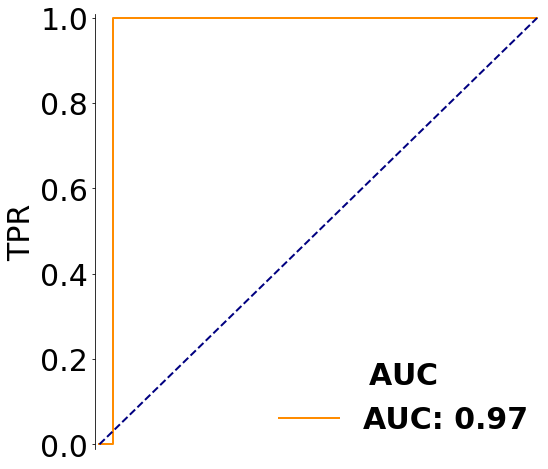

MUT.DCHS2 
 [False  True]


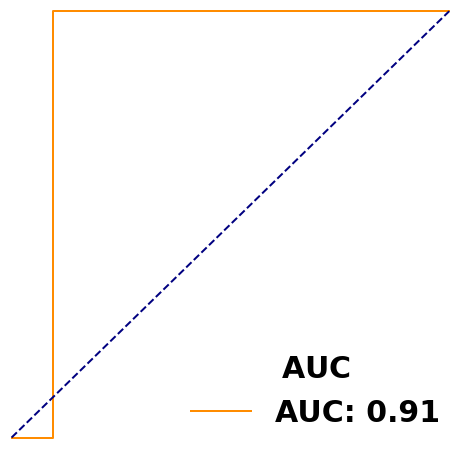

MUT.NRAS 
 [False  True]


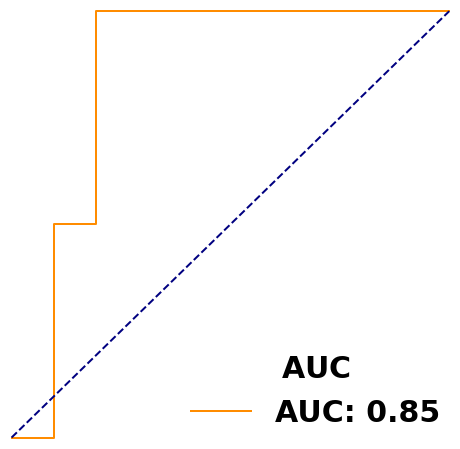

MUT.CTNNB1 
 [False  True]


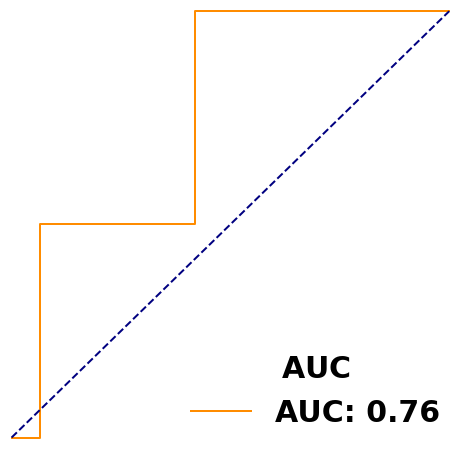

MUT.RNF43 
 [False  True]


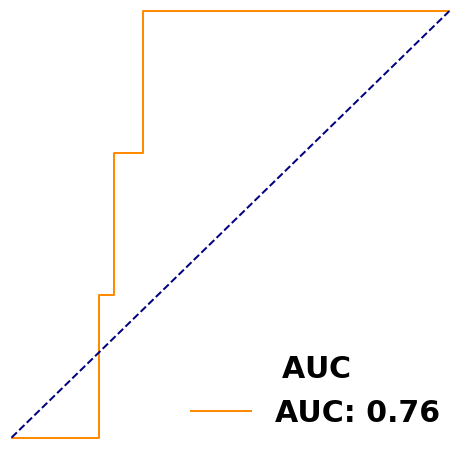

MUT.MGA 
 [False  True]


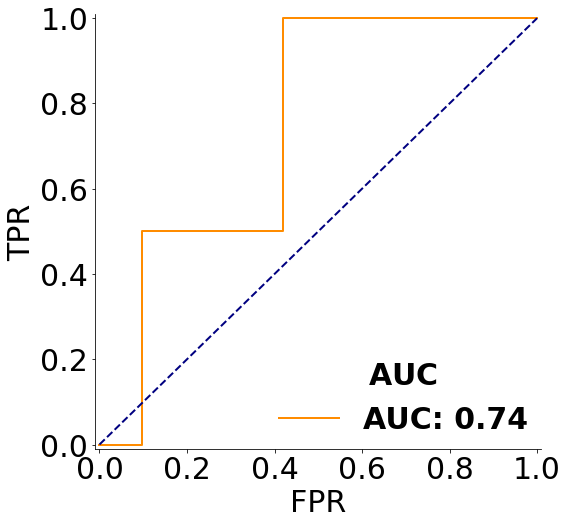

MUT.PTEN 
 [False  True]


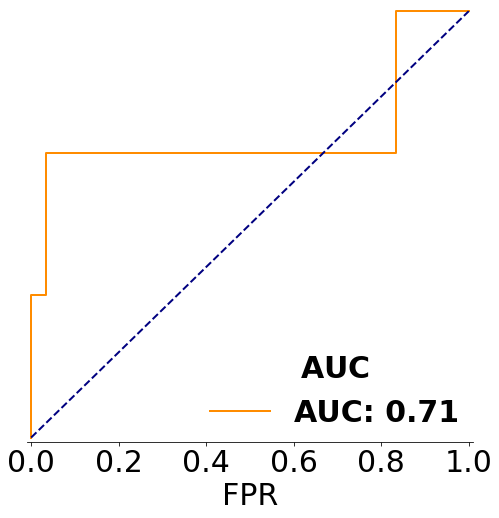

MUT.AMER1 
 [False  True]


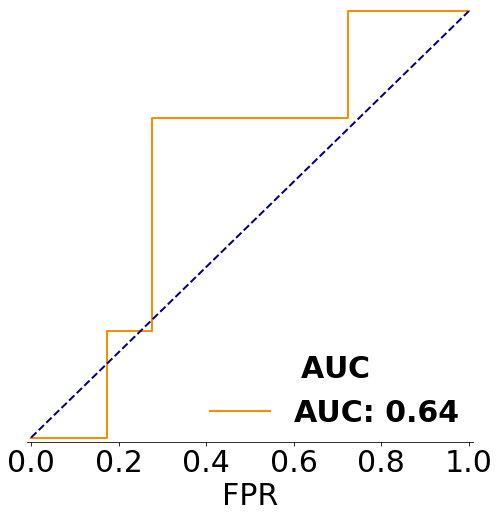

EPISIL.MGA 
 [False  True]


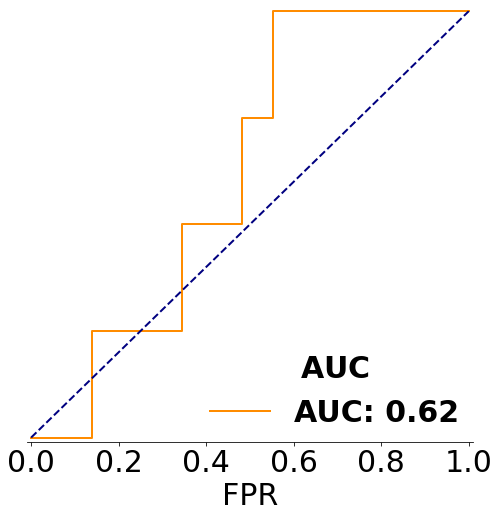

MUT.SPEN 
 [False  True]


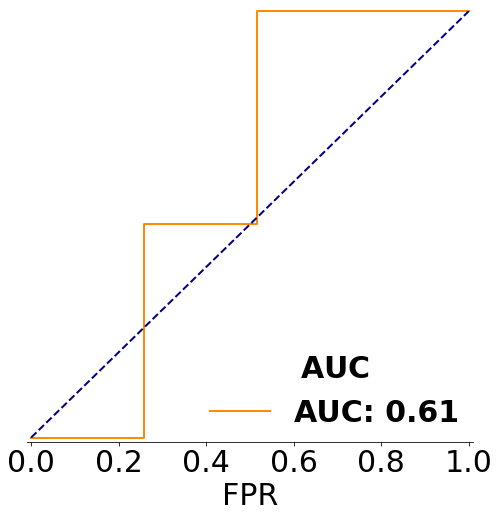

STAD
DEL.SMAD4 
 [False  True]


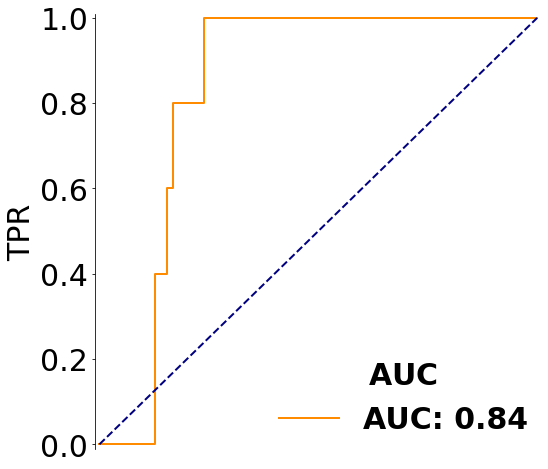

AMP.CCND3 
 [False  True]


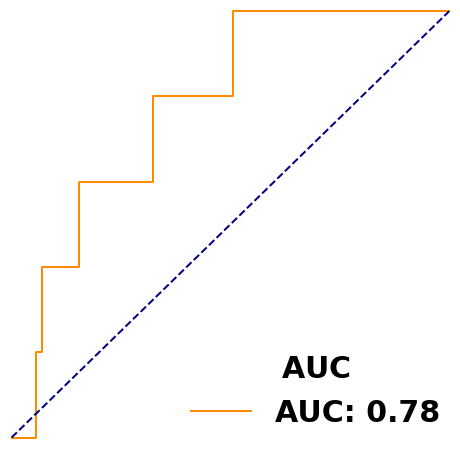

EPISIL.HES4 
 [False  True]


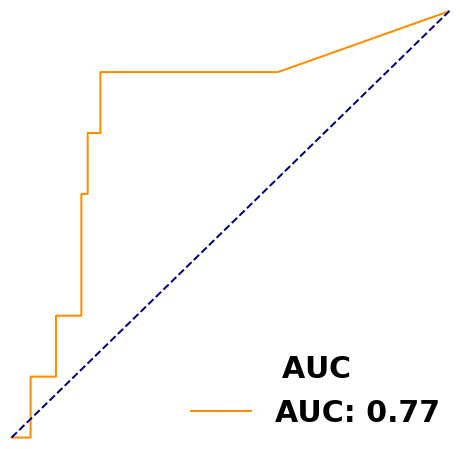

AMP.PIK3CA 
 [False  True]


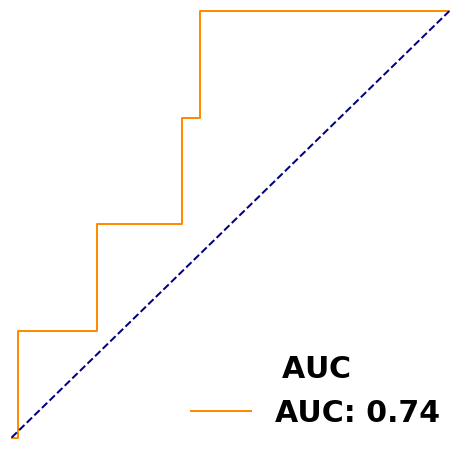

EPISIL.TCF7 
 [False  True]


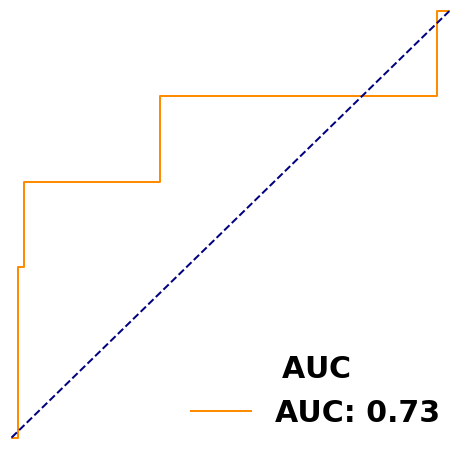

AMP.CCND1 
 [False  True]


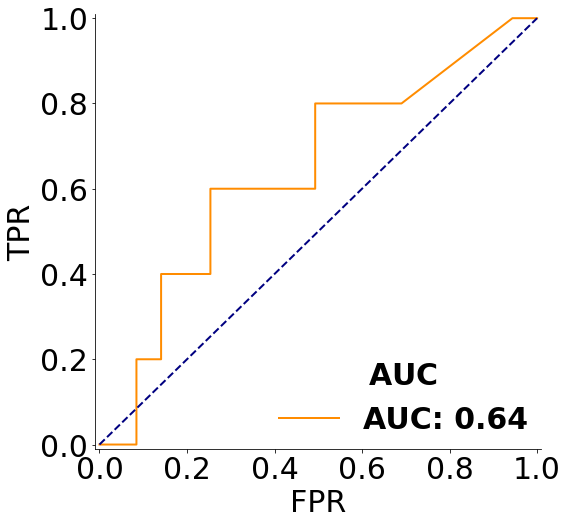

MUT.APC 
 [False  True]


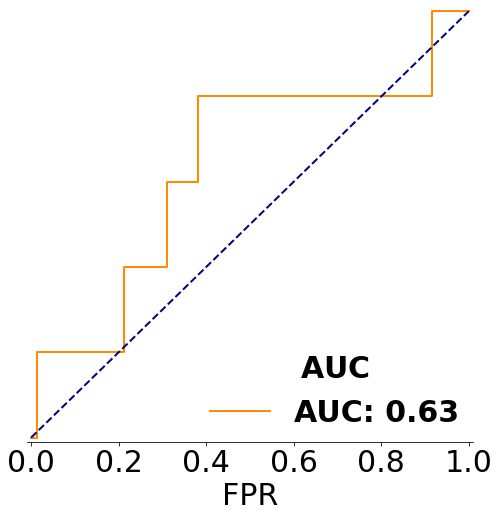

AMP.CCNE1 
 [False  True]


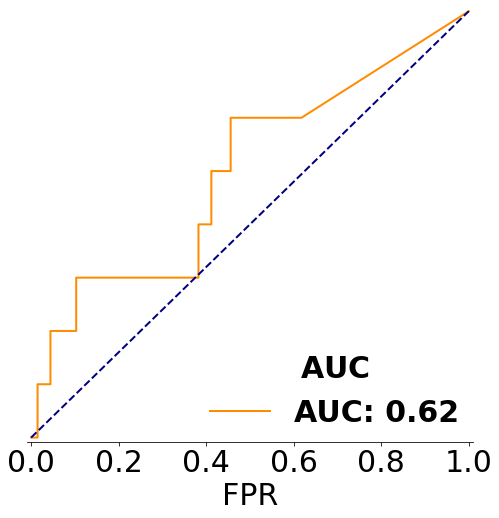

AMP.RICTOR 
 [False  True]


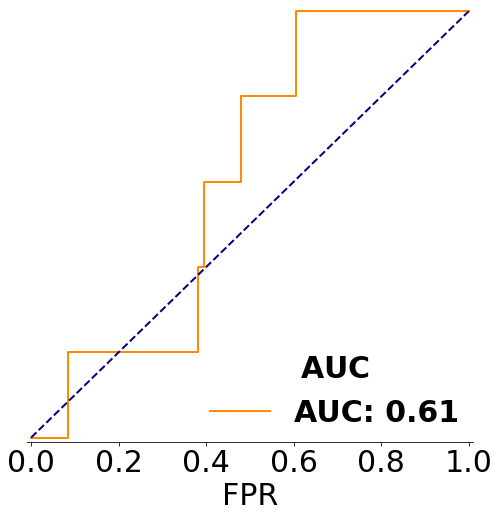

AMP.KRAS 
 [False  True]


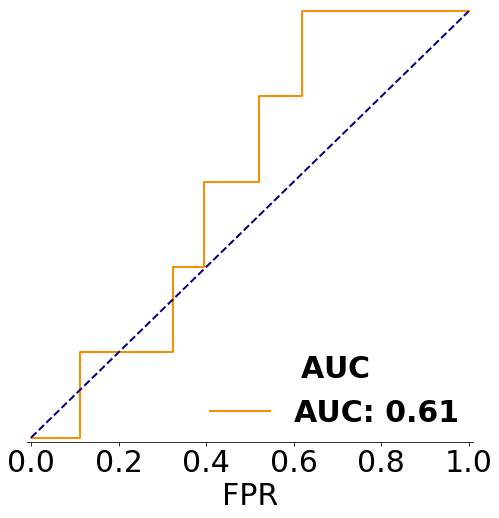

In [16]:
for CANCER in ['COAD', 'STAD']:
    print('=================================')
    print(CANCER)
    print('=================================')
    roc_curve_binary_all(disease=CANCER, plot_axis='default')

### For website "x1y1"

In [35]:
def roc_curve_binary_all(disease, fig_save_folder='./figures/ROC', variables=None, fontsize=30, bbox_to_anchor=(1.03, -0.03), 
                         plot_axis='x1y1', plot_num_per_row=5):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    import os

    pred_result_save_folder = './results/%s' % disease
    with open(os.path.join(pred_result_save_folder, '{}_prediction_result_dict.pkl'.format(disease)), 'rb') as f:
        prediction_result_dict = pickle.load(f)

    lrp_result_save_folder = './results/LRP/%s' % disease
    with open(os.path.join(lrp_result_save_folder, 'lrp_result_dict.pkl'.format(disease)), "rb") as f:
        lrp_result_dict = pickle.load(f)
    
    if variables is None:
        plot_var = lrp_result_dict['y_col_names']
    else:
        plot_var = variables
        
    n_row = np.ceil(len(plot_var)/plot_num_per_row)
    n_full_col = len(plot_var)%plot_num_per_row
       
    for idx, cov in enumerate(list(plot_var)):
        y_test_cov = prediction_result_dict['y_train_test'][cov][1]

        y_test = label_binarize(y_test_cov.values, classes=prediction_result_dict['classes'][cov])
        if y_test.shape[1]==1:
            y_test = np.hstack((1-y_test, y_test))
        y_score = prediction_result_dict['pred_proba'][cov].cpu().numpy()
        classes = prediction_result_dict['classes'][cov]
        print(cov, '\n', classes)
        
        # Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        tt = dict()
        
        fpr, tpr, tt = roc_curve(y_test[:, 1], y_score[:, 1])
        roc_auc = auc(fpr, tpr)
        stored_auc = prediction_result_dict['auc'][cov]
        
        fig, ax = plt.subplots(figsize=(8,8))
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        lw = 2
        
#         import matplotlib
#         cmap = matplotlib.cm.get_cmap('Set1')

        plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label=f"AUC: {stored_auc:0.2f}"
        )
        
        legend_properties = {'weight':'bold', 'size':fontsize}
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        
        if plot_axis == 'default':
            if idx%plot_num_per_row == 0 and  idx//plot_num_per_row == n_row-1: axis = 'x1y1'
            elif idx%plot_num_per_row == 0: axis = 'x0y1'
            elif idx//plot_num_per_row == n_row-1: axis = 'x1y0'
            elif idx%plot_num_per_row > n_full_col-1  and idx//plot_num_per_row == n_row-2: axis = 'x1y0'
            else: axis = 'x0y0'
        elif plot_axis in ['x1y1', 'x0y1', 'x1y0', 'x0y0']:
            axis = plot_axis
        else:
            raise ValueError("Please choose a value for argument 'axis' among "\
                             "{'default', 'x1y1', 'x0y1', 'x1y0', 'x0y0'}!")
        
        if axis == 'x1y1':
            plt.xlabel("FPR", fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.ylabel("TPR", fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
        elif axis == 'x0y1':
            ax.spines['bottom'].set_visible(False)
            
            plt.xlabel("")
            plt.xticks([])
            plt.ylabel("TPR", fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
        elif axis == 'x1y0':
            ax.spines['left'].set_visible(False)
            
            plt.xlabel("FPR", fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.ylabel("")
            plt.yticks([])
        elif axis == 'x0y0':
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        
            plt.xlabel("")
            plt.xticks([])
            plt.ylabel("")
            plt.yticks([])
        
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        
        legend = plt.legend(loc='lower right', bbox_to_anchor=bbox_to_anchor, title=r'$\bf{AUC}$', 
                            frameon=False, prop=legend_properties)
        title = legend.get_title()
        title.set_fontsize(fontsize)
        plt.show()
        
        os.makedirs(f"{fig_save_folder}/{disease}", exist_ok=True)
        fig.savefig(f"{fig_save_folder}/{disease}/{cov}_{axis}.png", bbox_inches='tight')

MUT.AMER1 
 [False  True]


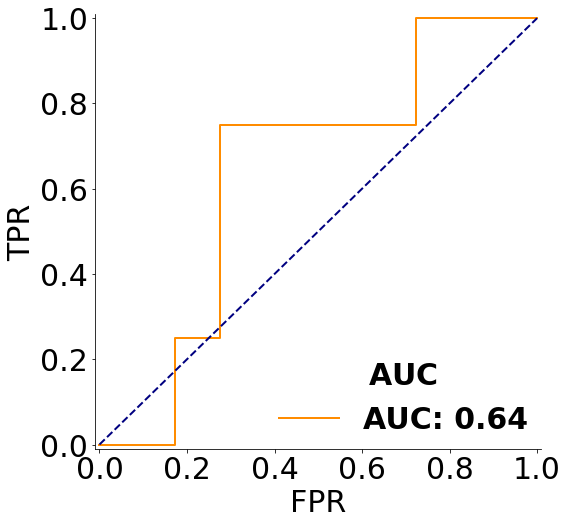

MUT.CTNNB1 
 [False  True]


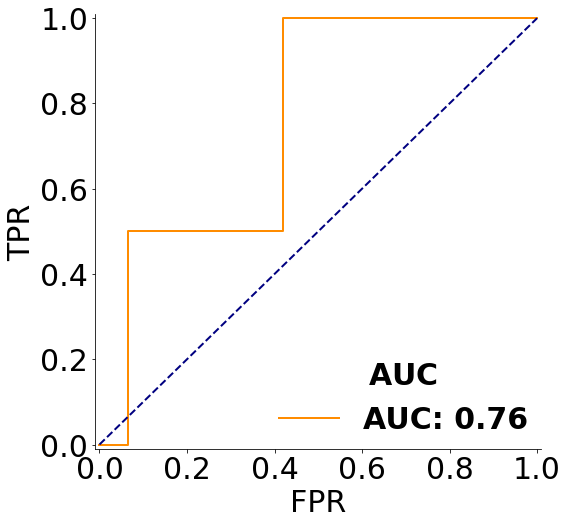

MUT.DCHS2 
 [False  True]


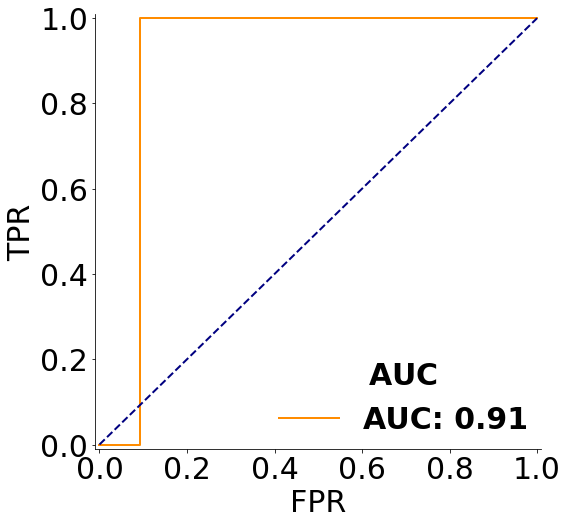

MUT.MGA 
 [False  True]


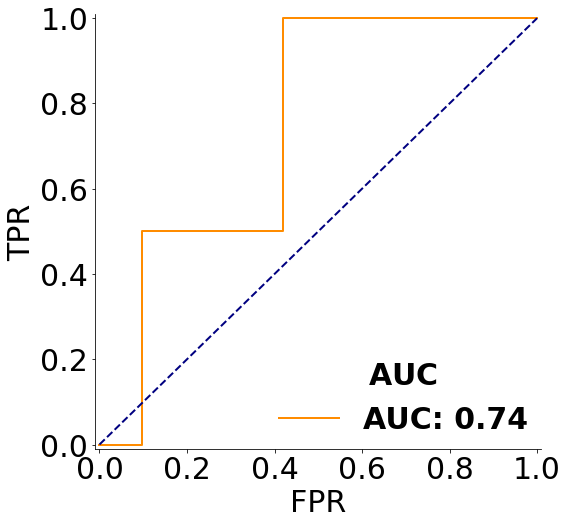

MUT.NRAS 
 [False  True]


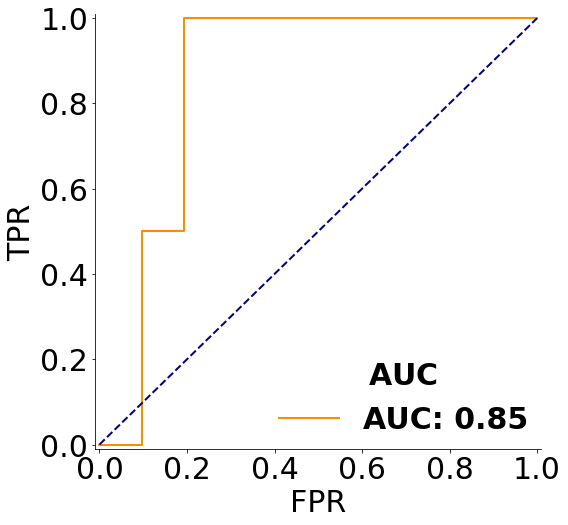

MUT.PTEN 
 [False  True]


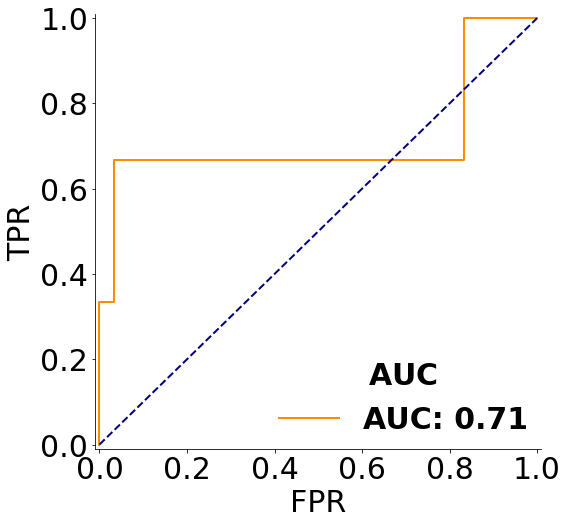

MUT.RB1 
 [False  True]


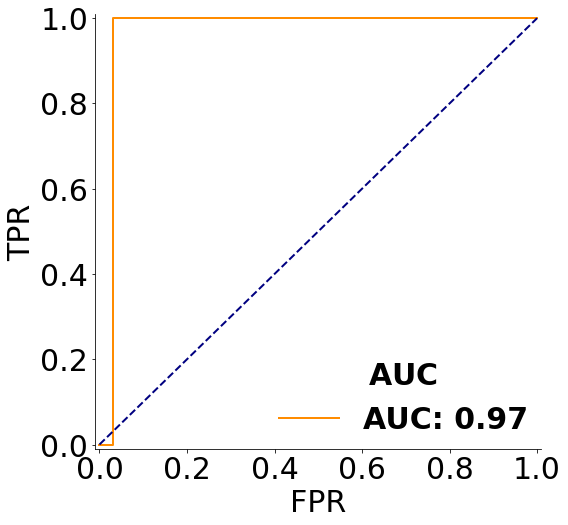

MUT.RNF43 
 [False  True]


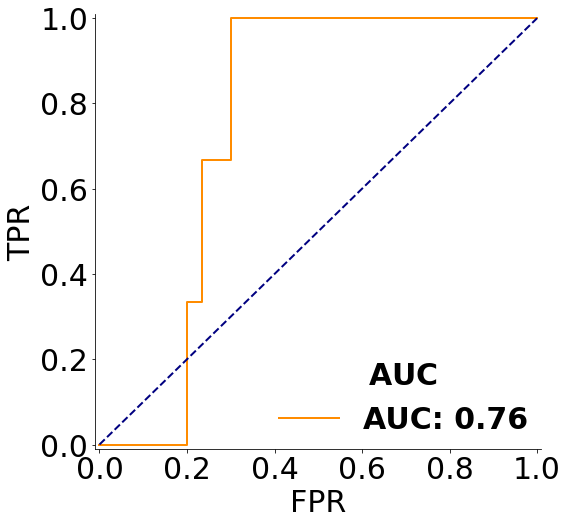

MUT.SPEN 
 [False  True]


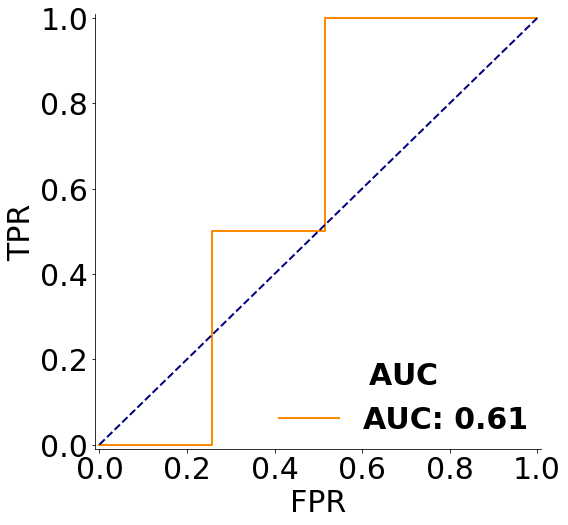

EPISIL.MGA 
 [False  True]


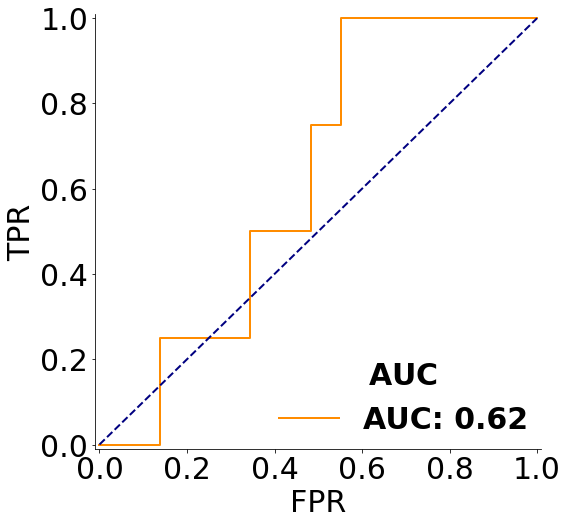

AMP.CCND1 
 [False  True]


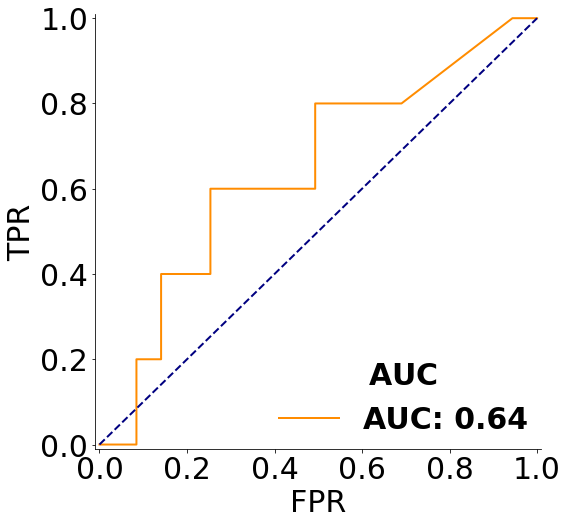

AMP.CCND3 
 [False  True]


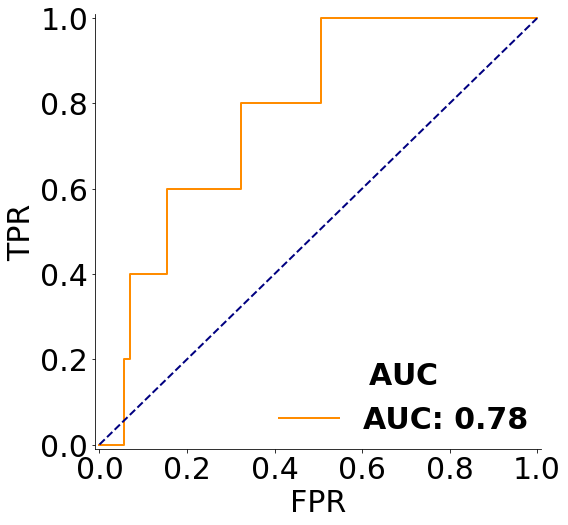

AMP.CCNE1 
 [False  True]


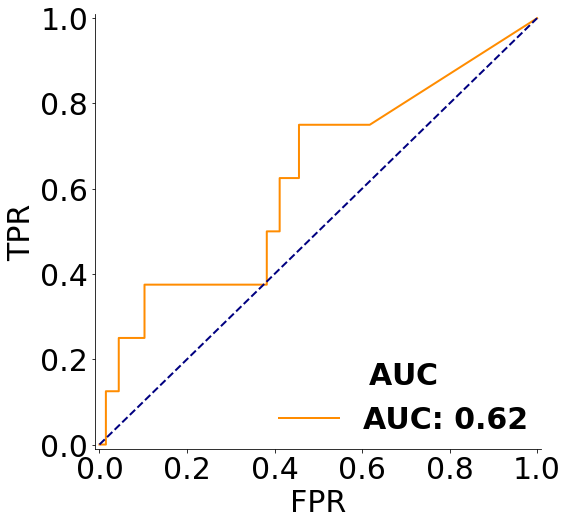

AMP.PIK3CA 
 [False  True]


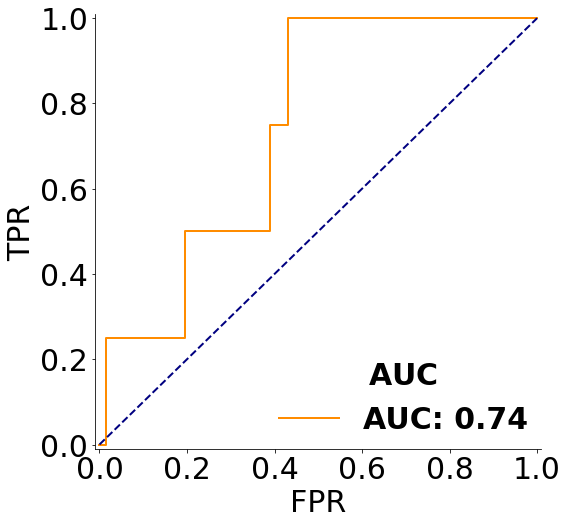

AMP.RICTOR 
 [False  True]


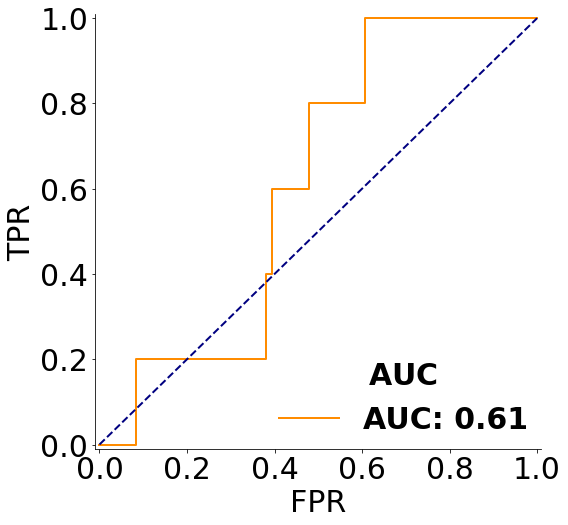

AMP.KRAS 
 [False  True]


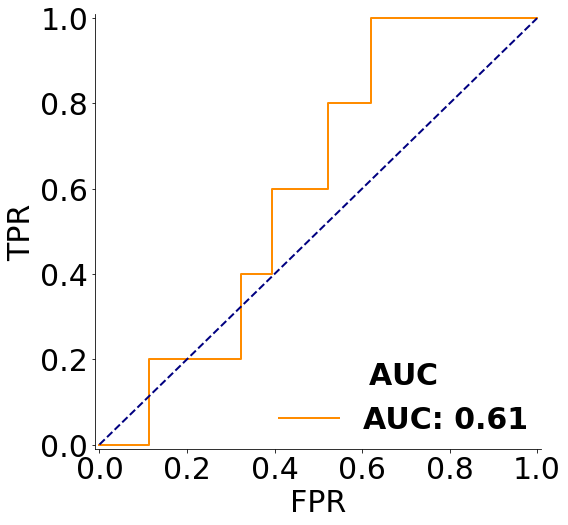

DEL.SMAD4 
 [False  True]


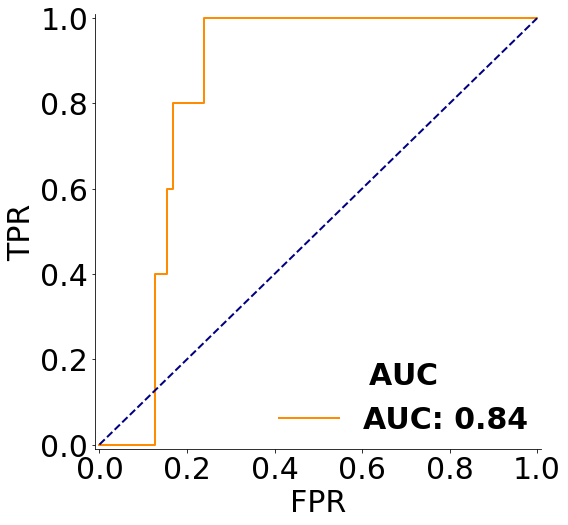

MUT.APC 
 [False  True]


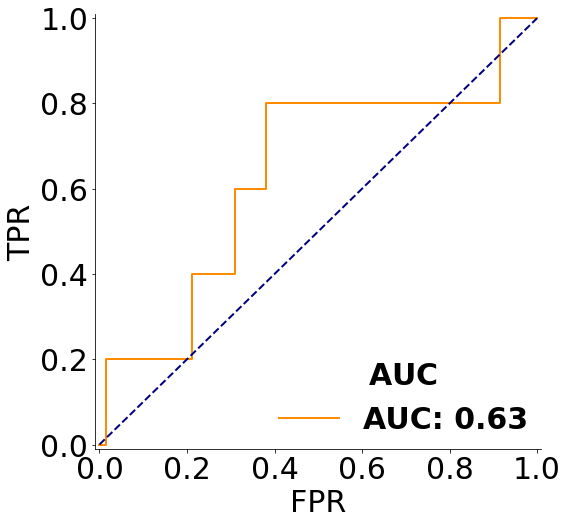

EPISIL.HES4 
 [False  True]


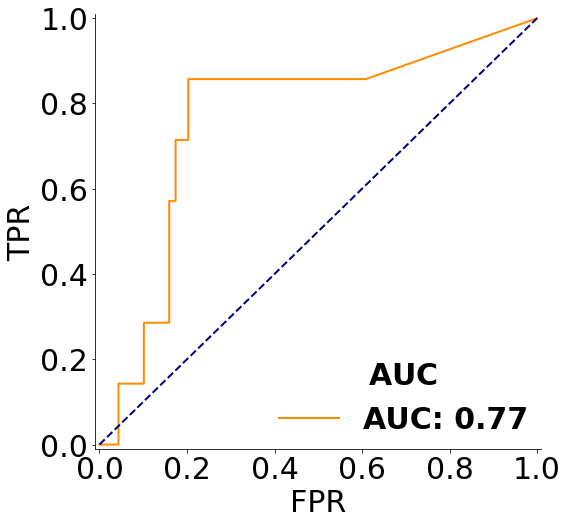

EPISIL.TCF7 
 [False  True]


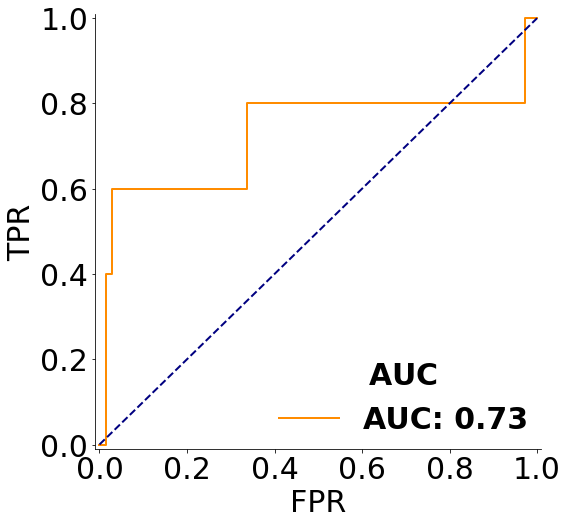

In [36]:
roc_curve_binary_all(disease='COAD', fig_save_folder='./figures/web_ROC', plot_axis='x1y1')
roc_curve_binary_all(disease='STAD', fig_save_folder='./figures/web_ROC', plot_axis='x1y1')

## Heatmap

In [33]:
def sort_influence(disease, save_folder='./', decreasing=True, covariate_list=None):
    with open(os.path.join(save_folder, f'results/LRP/{disease}/lrp_result_dict.pkl'), "rb") as f:
        lrp_result_dict = pickle.load(f)
    influence = lrp_result_dict['influence_by_microbe_all']
    row_names = lrp_result_dict['y_col_names'] if covariate_list is None else covariate_list
    column_names = pd.read_pickle(os.path.join(save_folder, 
                                               f'data/processed data/{disease}_microbiome_clean.pkl')).columns
    ### Sorted by col sum
    ascending_sort_idx_col = np.argsort(np.sum(influence, axis=0))
    sort_idx_col = ascending_sort_idx_col[::-1] if decreasing else ascending_sort_idx_col
    ### Sorted row by AUC scores
    sorted_auc_df = sorted_auc(disease, print_disease_name=False)
    sort_idx_row = np.array([np.where(rn == row_names)[0][0] for rn in sorted_auc_df['Covariate']])
    sorted_influence_df = pd.DataFrame(influence[sort_idx_row,:][:, sort_idx_col], 
                                columns = column_names[sort_idx_col], 
                                index = sorted_auc_df['Covariate'].values)
    return sorted_influence_df

In [34]:
def heatmap_influence(disease, influence_df, top_col_pct=0.05, plot=True, covariate_subset=None,
                      cmap="Blues", cbar=True, cmax=None, taxa_names=True, feature_names=True,
                      fontsize=16, font_scale=2.5, linewidths=0., horizontal=True, 
                      save=False, fig_save_folder='./figures'):
    
    import seaborn as sns
    taxa_name = list(influence_df.columns)
    genus_name = [tn.split('__')[-1] for tn in taxa_name]
    nona_idx = np.where(np.array(genus_name) != '')[0]
    genus_name_nona = np.array(genus_name)[nona_idx]
    
    influence_df_genus_lvl = influence_df.iloc[:, nona_idx]
    influence_df_genus_lvl.columns = list(genus_name_nona)
    
    n_col_selected = np.round(influence_df_genus_lvl.shape[1] * top_col_pct).astype(int)
    
    if covariate_subset is None:
        row_subset = influence_df_genus_lvl.index
    else:
        row_subset = covariate_subset
    
    influence_df_genus_lvl_marker = influence_df_genus_lvl.loc[row_subset, influence_df_genus_lvl.columns[:n_col_selected]]
    if top_col_pct==1.: 
        influence_df_genus_lvl_marker.to_csv(f'./results/LRP/{disease}/sorted_influence_df.csv')
    else:
        influence_df_genus_lvl_marker.to_csv(f'./results/LRP/{disease}/sorted_influence_df_pct{str(int(top_col_pct*100))}.csv')

    if plot:
        if horizontal:
            figheight = len(row_subset)*2-2
            figwidth = n_col_selected*2
            fig, ax = plt.subplots(figsize=(figwidth, figheight))
            print(influence_df_genus_lvl_marker.T.shape)
            hm = sns.heatmap(influence_df_genus_lvl_marker, linewidths=linewidths, cbar=cbar, cbar_kws={"pad":0.01}, 
                            cmap=cmap, vmin=0, vmax=cmax)
            if taxa_names: hm.set_xticklabels(hm.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor', fontsize=fontsize)
            else: hm.set_xticklabels([])
            if feature_names: hm.set_yticklabels(hm.get_yticklabels(), fontsize=fontsize, rotation=0, ha='right')
            else: hm.set_yticklabels([])
        else:
            figwidth = len(row_subset)*2-2
            figheight = n_col_selected*2
            fig, ax = plt.subplots(figsize=(figwidth, figheight))
            # Use transposed DF
            print(influence_df_genus_lvl_marker.T.shape)
            hm = sns.heatmap(influence_df_genus_lvl_marker.T, linewidths=linewidths, cbar=cbar, cbar_kws={"pad":0.01, "orientation":"horizontal"}, 
                            cmap=cmap, vmin=0, vmax=cmax)
            if taxa_names: hm.set_yticklabels(hm.get_yticklabels(), rotation=30, ha='right', rotation_mode='anchor', fontsize=fontsize+10)
            else: hm.set_yticklabels([])
            if feature_names: hm.set_xticklabels(hm.get_xticklabels(), fontsize=fontsize-5, rotation=30, ha='left')
            else: hm.set_xticklabels([])
        # want a more natural, table-like display
        ax.tick_params(top = False, labelbottom=False, labeltop=True)
        sns.set(font_scale=font_scale)
        if cmax is None: cmax = np.max(np.array(influence_df).reshape(-1))
        hm.figure.axes[-1].yaxis.label.set_size(40)
        # use matplotlib.colorbar.Colorbar object
        if cbar==True:
            cbar = hm.collections[0].colorbar
            cbar.ax.tick_params(labelsize=40)
        plt.show()
    
        if save:
            os.makedirs(f"{fig_save_folder}", exist_ok=True)
            fig.savefig(f"{fig_save_folder}/biomarker_heatmap_{disease}.pdf", bbox_inches='tight')
            fig.savefig(f"{fig_save_folder}/biomarker_heatmap_{disease}.png", bbox_inches='tight')
    
    return influence_df_genus_lvl_marker

In [35]:
COAD_sorted_influence_df = sort_influence('COAD')
np.max(np.array(COAD_sorted_influence_df).reshape(-1))

163.55771

(62, 10)


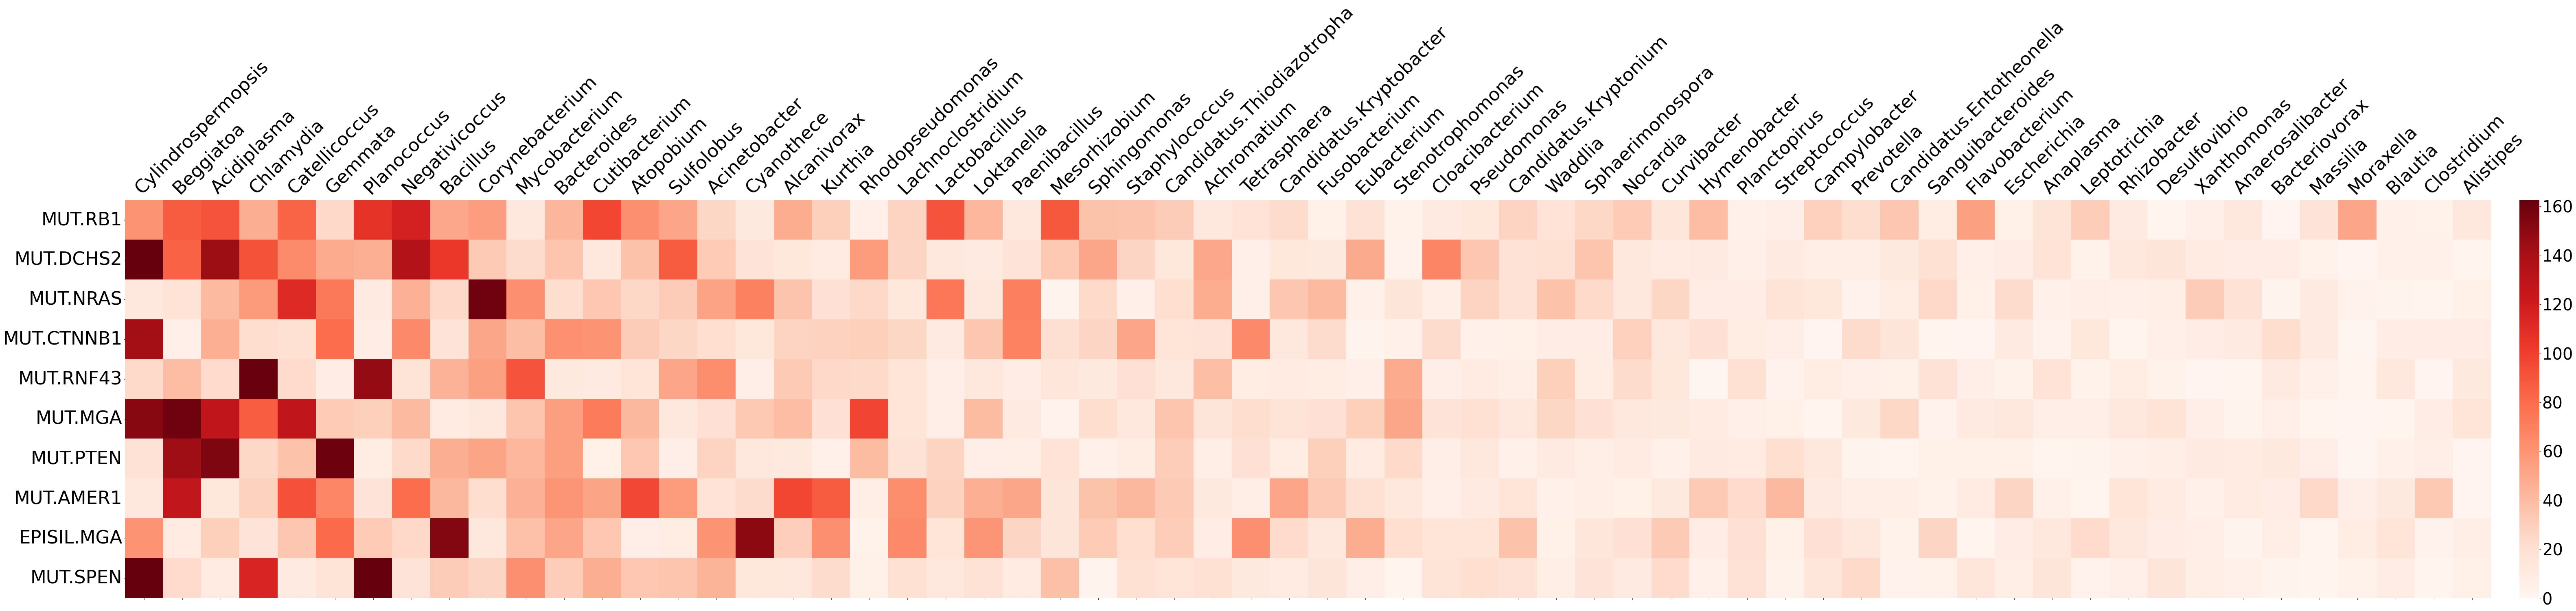

In [35]:
COAD_sorted_influence_df_subset = heatmap_influence('COAD', COAD_sorted_influence_df, cmap="Reds", #"Blues", "YlOrBr", "Reds"
                                                    cbar=True, top_col_pct=0.05, save=False, taxa_names=True, fontsize=45,
                                                    horizontal=True)

(62, 10)


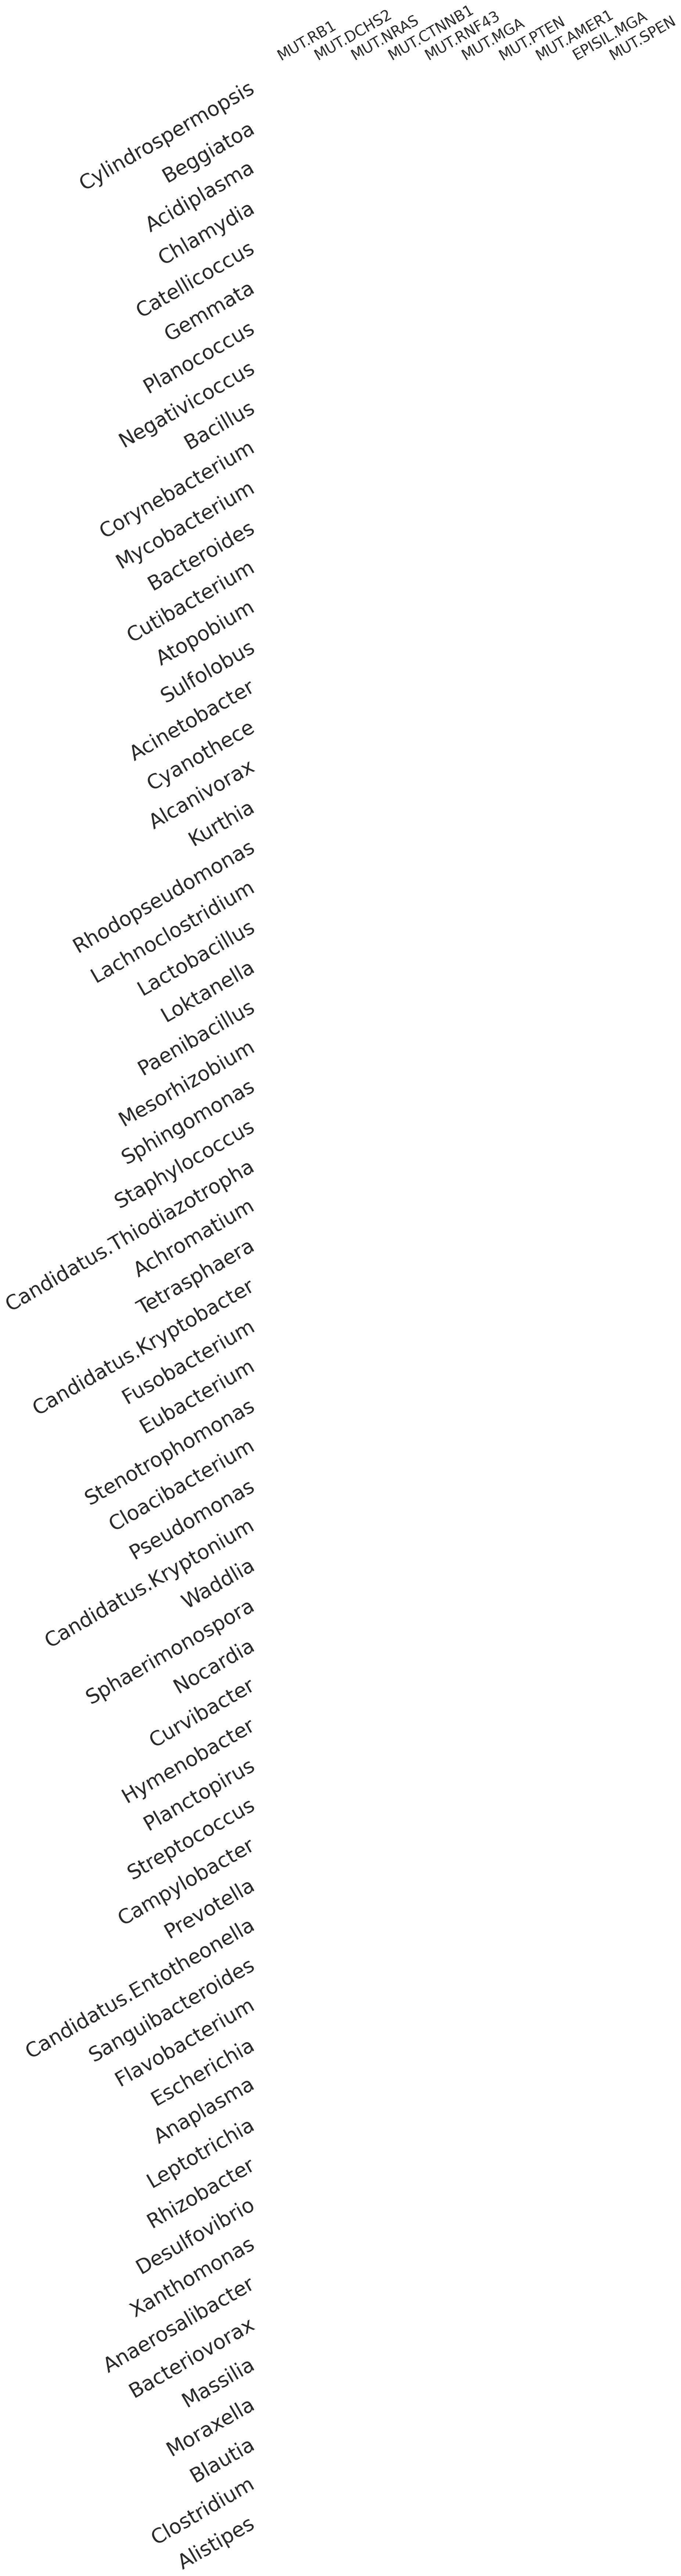

In [70]:
from matplotlib.colors import ListedColormap
COAD_sorted_influence_df_subset = heatmap_influence('COAD', COAD_sorted_influence_df, cmap=ListedColormap(['white']), #"Blues", "YlOrBr", "Reds"
                                                    cbar=False, top_col_pct=0.05, save=True, taxa_names=True, fontsize=45,
                                                    horizontal=False, feature_names=True)

(62, 10)


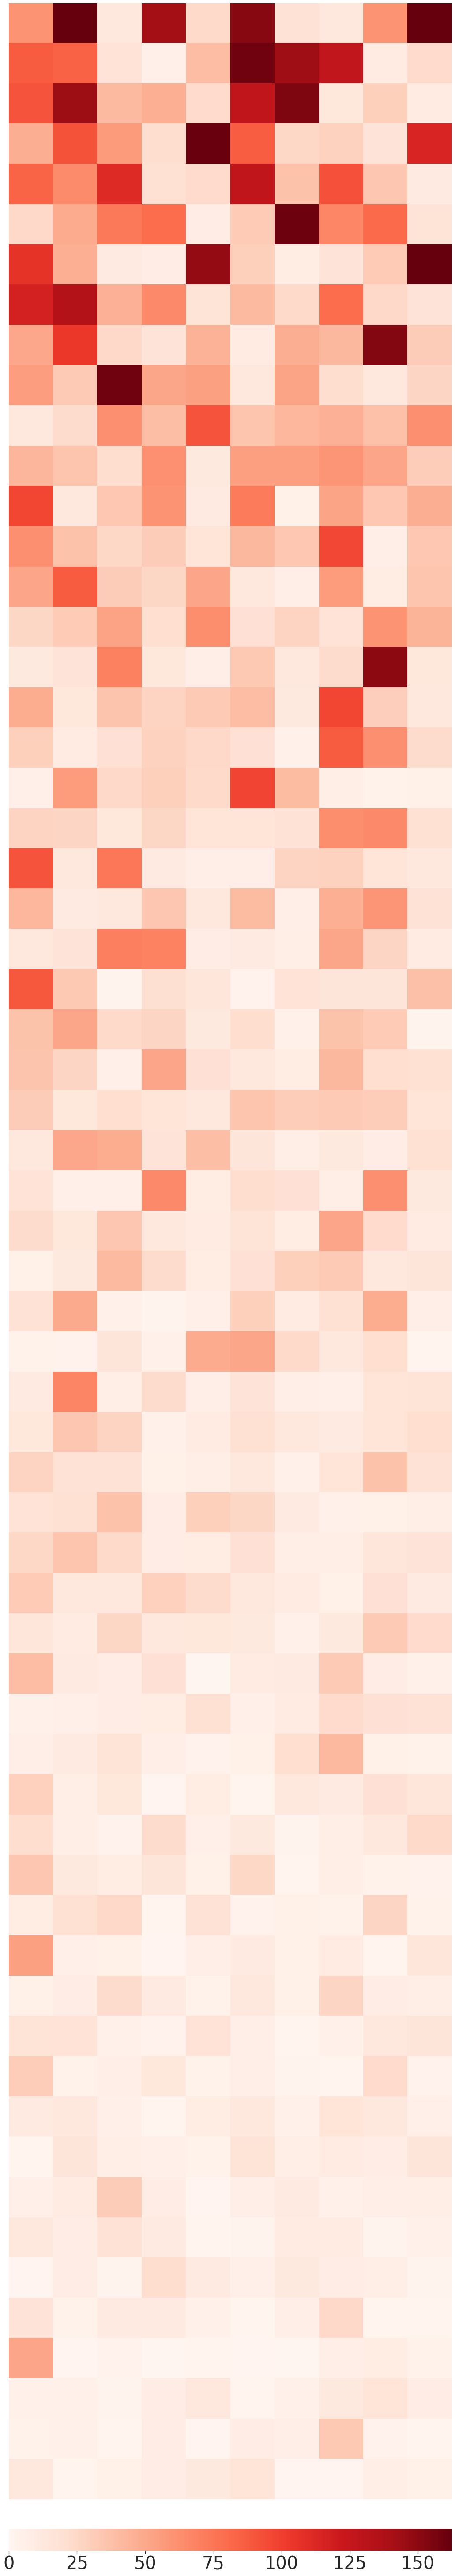

In [71]:
COAD_sorted_influence_df_subset = heatmap_influence('COAD', COAD_sorted_influence_df, cmap="Reds", #"Blues", "YlOrBr", "Reds"
                                                    cbar=True, top_col_pct=0.05, save=True, taxa_names=False, fontsize=45,
                                                    horizontal=False, feature_names=False)

In [58]:
COAD_sorted_influence_df_subset = heatmap_influence('COAD', COAD_sorted_influence_df, top_col_pct=0.01, plot=False)

In [59]:
COAD_sorted_influence_df_subset = heatmap_influence('COAD', COAD_sorted_influence_df, top_col_pct=1., plot=False)

In [60]:
COAD_sorted_influence_df_subset

Cylindrospermopsis   Beggiatoa  Acidiplasma   Chlamydia  \
MUT.RB1              60.181076   87.122490    91.017540   47.592628   
MUT.DCHS2           162.204712   84.478180   144.298569   91.770607   
MUT.NRAS             12.919230   18.193913    40.716888   56.942303   
MUT.CTNNB1          142.218384    6.008076    46.381042   22.101719   
MUT.RNF43            23.721287   39.362602    23.358835  161.781631   
MUT.MGA             151.113541  159.856384   128.090271   86.625320   
MUT.PTEN             18.847452  144.081543   154.430191   25.371895   
MUT.AMER1            13.220505  127.431870    14.512625   28.406475   
EPISIL.MGA           60.911846    9.770930    29.716080   16.844658   
MUT.SPEN            162.503723   23.064379     9.907620  114.718704   

            Catellicoccus     Gemmata  Planococcus  Negativicoccus  \
MUT.RB1         83.978630   24.661657   106.138596      116.873283   
MUT.DCHS2       64.411873   48.307438    46.823963      133.999756   
MUT.NRAS       111.685310   73.766937    10.903213       45.974567   
MUT.CTNNB1      19.910404   79.457024     8.865734       65.871841   
MUT.RNF43       23.078146    7.858616   147.346451       17.206202   
MUT.MGA        128.059174   31.869350    29.367428       40.718769   
MUT.PTEN        37.361206  160.541473     9.393372       23.499205   
MUT.AMER1       92.557060   67.205917    16.734999       79.520187   
EPISIL.MGA      34.685379   80.801758    32.167805       24.524429   
MUT.SPEN        11.376639   17.614735   161.967819       16.700069   

              Bacillus  Corynebacterium  ...  Neofamilia  Oceanibaculum  \
MUT.RB1      50.720955        55.512287  ...    0.006536       0.005939   
MUT.DCHS2   103.803932        32.390472  ...    0.009624       0.010922   
MUT.NRAS     24.357708       159.841614  ...    0.004254       0.003616   
MUT.CTNNB1   16.818268        51.206585  ...    0.004701       0.006116   
MUT.RNF43    45.341045        54.300438  ...    0.005877       0.002959   
MUT.MGA       9.652778        13.860950  ...    0.002238       0.002512   
MUT.PTEN     47.425846        52.601463  ...    0.002775       0.003140   
MUT.AMER1    42.298870        21.947666  ...    0.003725       0.003162   
EPISIL.MGA  153.306595        12.678023  ...    0.002449       0.004120   
MUT.SPEN     31.415077        26.445547  ...    0.005359       0.004876   

            Acidithiobacillus  Mucispirillum  Stanieria  Pseudolabrys  \
MUT.RB1              0.007895       0.006048   0.005124      0.008631   
MUT.DCHS2            0.008648       0.009500   0.010049      0.003816   
MUT.NRAS             0.004882       0.003899   0.004995      0.004792   
MUT.CTNNB1           0.006279       0.005976   0.005056      0.004559   
MUT.RNF43            0.004347       0.002499   0.003416      0.006191   
MUT.MGA              0.002977       0.002724   0.004767      0.003491   
MUT.PTEN             0.002877       0.001706   0.001796      0.002667   
MUT.AMER1            0.002140       0.007136   0.003866      0.003408   
EPISIL.MGA           0.002954       0.002825   0.002400      0.003782   
MUT.SPEN             0.004153       0.004472   0.005100      0.004981   

            Paenalcaligenes  Stackebrandtia  Minicystis  Mucinivorans  
MUT.RB1            0.005834        0.006551    0.005182      0.002853  
MUT.DCHS2          0.005883        0.003955    0.007444      0.006355  
MUT.NRAS           0.005678        0.003920    0.003641      0.001707  
MUT.CTNNB1         0.009785        0.004932    0.007211      0.001618  
MUT.RNF43          0.001973        0.005983    0.003217      0.001732  
MUT.MGA            0.003151        0.003983    0.003368      0.000916  
MUT.PTEN           0.001981        0.002212    0.001746      0.000858  
MUT.AMER1          0.004303        0.004567    0.003084      0.000860  
EPISIL.MGA         0.002577        0.002667    0.004135      0.001937  
MUT.SPEN           0.004394        0.004540    0.003290      0.005335  

[10 rows x 1240 columns]

---

In [36]:
STAD_sorted_influence_df = sort_influence('STAD')

(62, 10)


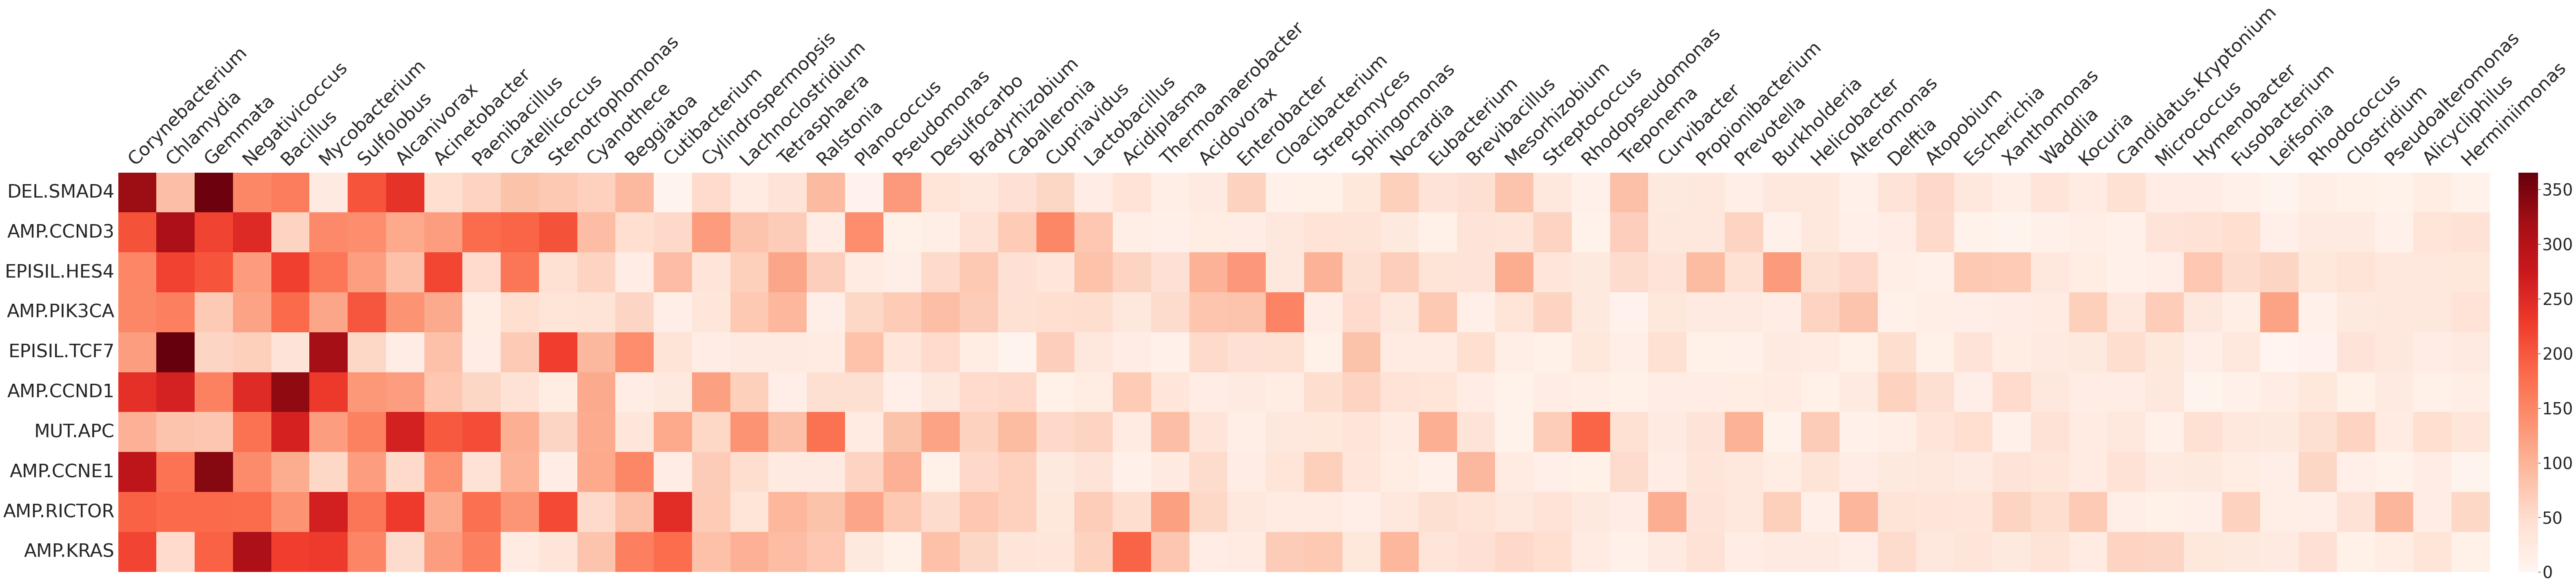

In [62]:
STAD_sorted_influence_df_subset = heatmap_influence('STAD', STAD_sorted_influence_df, cmap="Reds", #"Blues", "YlOrBr", "Reds"
                                                    cbar=True, top_col_pct=0.05, save=False, taxa_names=True, fontsize=45,
                                                    horizontal=True)

(62, 10)


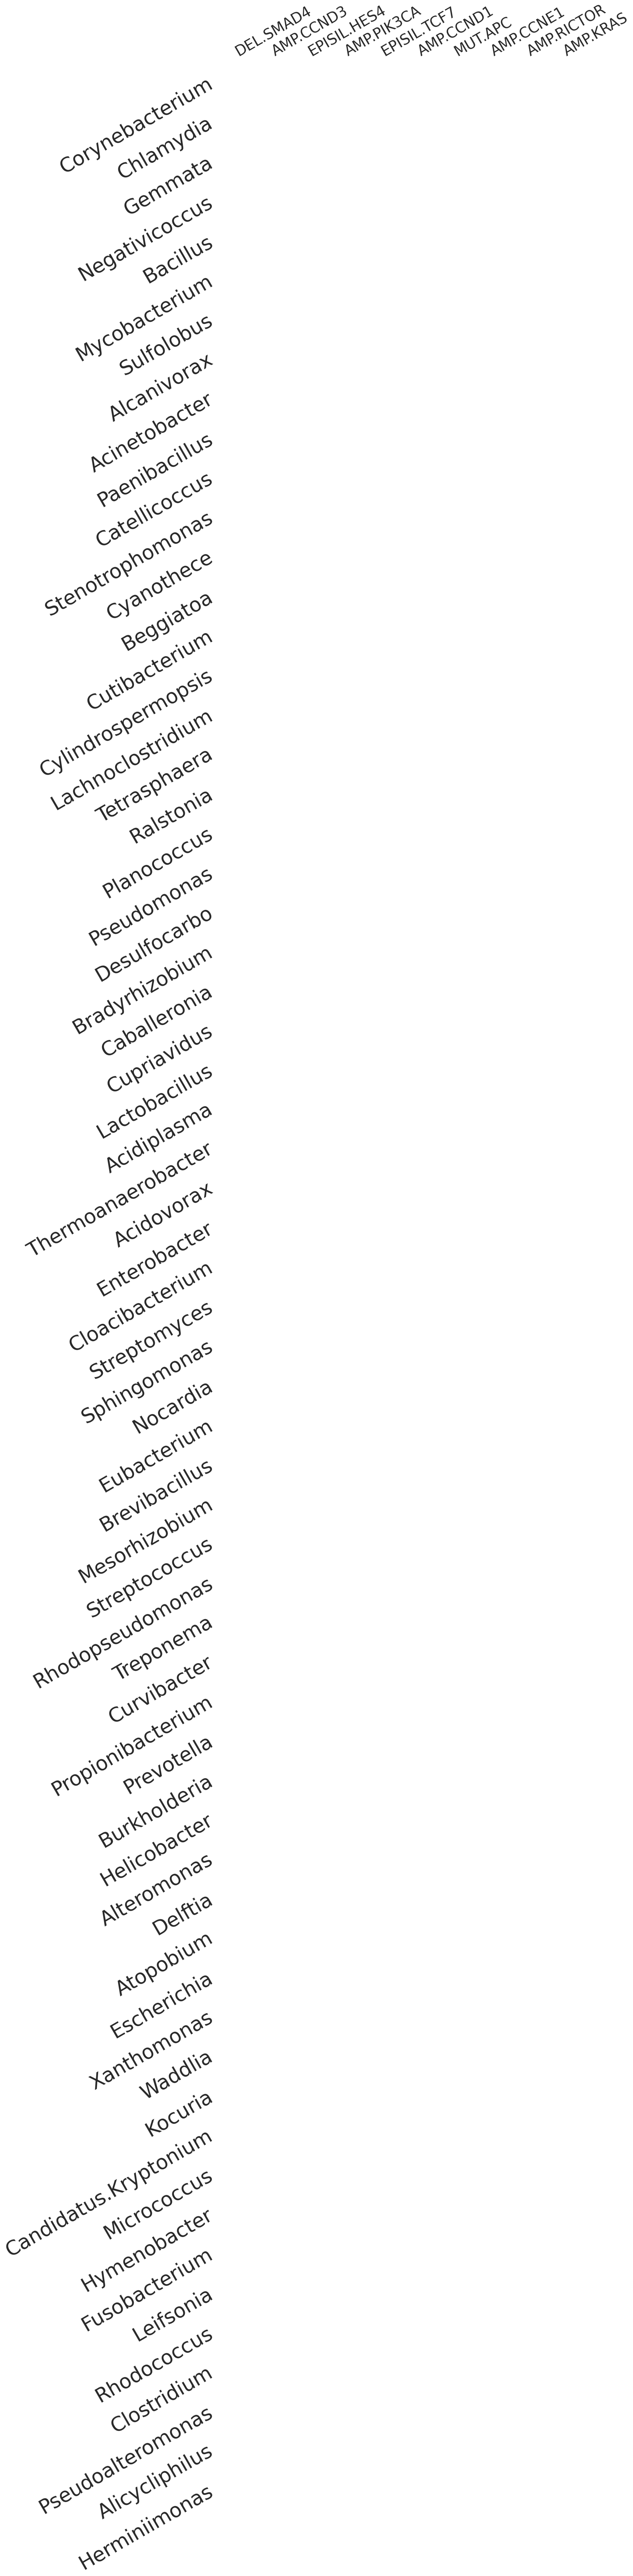

In [39]:
from matplotlib.colors import ListedColormap
STAD_sorted_influence_df_subset = heatmap_influence('STAD', STAD_sorted_influence_df, cmap=ListedColormap(['white']), #"Blues", "YlOrBr", "Reds"
                                                    cbar=False, top_col_pct=0.05, save=True, taxa_names=True, fontsize=45,
                                                    horizontal=False, feature_names=True)

(62, 10)


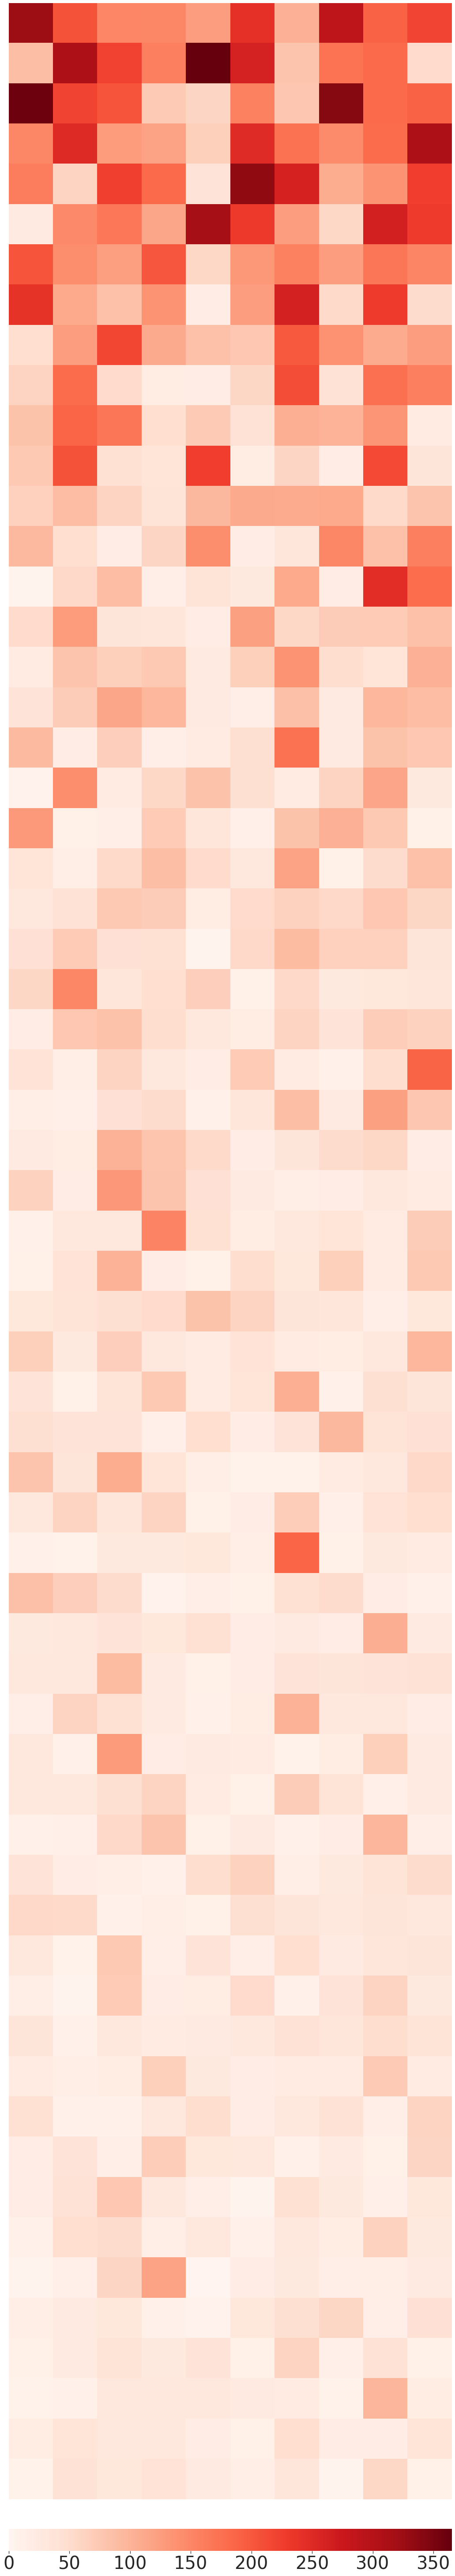

In [38]:
STAD_sorted_influence_df_subset = heatmap_influence('STAD', STAD_sorted_influence_df, cmap="Reds", #"Blues", "YlOrBr", "Reds"
                                                    cbar=True, top_col_pct=0.05, save=True, taxa_names=False, fontsize=45,
                                                    horizontal=False, feature_names=False)

In [64]:
STAD_sorted_influence_df_subset = heatmap_influence('STAD', STAD_sorted_influence_df, top_col_pct=0.01, plot=False)

In [65]:
STAD_sorted_influence_df_subset = heatmap_influence('STAD', STAD_sorted_influence_df, top_col_pct=1., plot=False)

In [66]:
STAD_sorted_influence_df_subset

Corynebacterium   Chlamydia     Gemmata  Negativicoccus  \
DEL.SMAD4         326.385895   87.793182  359.794006      149.311798   
AMP.CCND3         206.557327  309.426849  221.042465      250.602264   
EPISIL.HES4       150.204010  221.935989  203.090302      126.025261   
AMP.PIK3CA        148.931717  158.631882   72.943657      119.388641   
EPISIL.TCF7       124.259323  365.418152   58.699211       66.332802   
AMP.CCND1         242.179382  261.772125  156.156036      249.553497   
MUT.APC           103.008743   80.655571   77.629723      173.445801   
AMP.CCNE1         290.493652  172.504654  342.563782      145.122513   
AMP.RICTOR        190.164581  181.632492  182.357361      181.035980   
AMP.KRAS          218.479477   52.270931  189.992813      308.615997   

               Bacillus  Mycobacterium  Sulfolobus  Alcanivorax  \
DEL.SMAD4    160.077515      22.858152  203.577942   239.603470   
AMP.CCND3     61.088261     145.746506  141.585724   112.166374   
EPISIL.HES4  225.111832     167.117844  123.374268    84.471840   
AMP.PIK3CA   181.484055     115.089714  201.518463   134.614944   
EPISIL.TCF7   38.418026     319.570496   56.927265    19.864666   
AMP.CCND1    334.247650     230.560333  131.713760   125.514442   
MUT.APC      260.446960     124.695854  156.523987   263.387360   
AMP.CCNE1    108.352074      56.465897  125.011528    53.330708   
AMP.RICTOR   134.779373     265.365021  168.904388   229.000076   
AMP.KRAS     225.965271     228.676376  152.554657    50.777813   

             Acinetobacter  Paenibacillus  ...  Salinispora  \
DEL.SMAD4        47.475094      61.751198  ...     0.000048   
AMP.CCND3       124.727654     180.504089  ...     0.000004   
EPISIL.HES4     217.122391      52.444664  ...     0.000014   
AMP.PIK3CA      110.815056      21.174082  ...     0.000003   
EPISIL.TCF7      84.883965      19.593456  ...     0.000024   
AMP.CCND1        76.581436      57.841053  ...     0.000008   
MUT.APC         198.939545     212.258728  ...     0.000029   
AMP.CCNE1       138.233307      41.870502  ...     0.000024   
AMP.RICTOR      108.934128     176.960190  ...     0.000056   
AMP.KRAS        124.189255     157.523895  ...     0.000007   

             Candidatus.Jidaibacter  Ectothiorhodospira  Thiorhodovibrio  \
DEL.SMAD4                  0.000034            0.000012         0.000037   
AMP.CCND3                  0.000035            0.000045         0.000003   
EPISIL.HES4                0.000007            0.000013         0.000010   
AMP.PIK3CA                 0.000002            0.000002         0.000002   
EPISIL.TCF7                0.000029            0.000012         0.000019   
AMP.CCND1                  0.000005            0.000020         0.000006   
MUT.APC                    0.000018            0.000013         0.000024   
AMP.CCNE1                  0.000025            0.000016         0.000017   
AMP.RICTOR                 0.000019            0.000002         0.000043   
AMP.KRAS                   0.000033            0.000037         0.000007   

             Hydrogenoanaerobacterium  Methylocapsa  Oceanimonas  Afifella  \
DEL.SMAD4                    0.000012      0.000014     0.000007  0.000004   
AMP.CCND3                    0.000043      0.000032     0.000022  0.000023   
EPISIL.HES4                  0.000014      0.000010     0.000006  0.000007   
AMP.PIK3CA                   0.000004      0.000013     0.000012  0.000011   
EPISIL.TCF7                  0.000012      0.000013     0.000010  0.000009   
AMP.CCND1                    0.000019      0.000018     0.000015  0.000013   
MUT.APC                      0.000014      0.000005     0.000004  0.000006   
AMP.CCNE1                    0.000015      0.000006     0.000010  0.000008   
AMP.RICTOR                   0.000001      0.000006     0.000005  0.000004   
AMP.KRAS                     0.000032      0.000007     0.000006  0.000004   

             Psychrobacillus  Pseudospirillum  
DEL.SMAD4       5.427320e-07     5.335297e-0